In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Preparando kernel
import pandas as pd
!pip3 install pickle5
import pickle5 as pickl
import numpy as np
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.1/132.1 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pickle5: filename=pickle5-0.0.11-cp310-cp310-linux_x86_64.whl size=255314 sha256=094ad9826722514c6d20b2d16f0cd503e1a1356de610f98faba1d7f20f2c412d
  Stored in directory: /root/.cache/pip/wheels/7d/14/ef/4aab19d27fa8e58772be5c71c16add0426acf9e1f64353235c
Successfully built pickle5


In [ ]:
# Montando o Google drive
from google.colab import drive
drive.mount('/content/drive')
# Para ler/carregar
path = '/content/drive/MyDrive/PFG_Mateus_Ferreira/'           #Path do Mateus
#path = '/content/drive/MyDrive/PFG_EQ/PFG_Mateus_Ferreira/'   #Path do Torres
with open(path + 'databank_properties_2022.pickle', 'rb') as handle:
    dados, all_units = pickl.load(handle)
dados.shape
# Incluindo uma pasta do drive (mounted) no path do COLAB
import sys
sys.path.append(path)
# Carregamento das funções úteis
from OU3_funcoes_uteis_v05_2 import *
import TEQ_funcoes_uteis_v06 as teq
import OU3_funcoes_uteis_v05_2 as ou3

Mounted at /content/drive


#O Objetivo é criar um simulador através de uma função onde se entra com os parâmetros da coluna na forma de um dicionário e com a lista de componentes e ele simula o processo devolvendo os resultados.

In [ ]:
#Lista com os componentes do sistema:
#
lista_componentes = [122, 62, 20] #Acetona, metanol e água (respectivamente)

In [1]:
dados[dados['num'].isin(lista_componentes)]

NameError: ignored

In [ ]:
# Verificando os pontos de ebulição de nossos componentes a fim de escolher o valor intermediário para nossa T_flash
T_eb_comp = dados[dados['num'].isin(lista_componentes)]['boiling_point']
T_eb_comp = T_eb_comp.tolist()
T_eb_comp

[329.4, 337.8, 373.2]

In [ ]:
n_F    = 100 # mol/s -  Vazão molar da alimentação
z_F    = [0.3, 0.3, 0.4] # [Acetona, metanol, água]
P      = 760 # mmHg
T_F    = sum(T_eb_comp)/len(T_eb_comp) # K - Temperatura da alimentação - Usando a média das temperaturas
netc   = 10
# Esse aqui seria o NETS: j = n + 2 # esse dois a mais é o reboiler e o condensador
j_alim = 5 # estágio em relação somente à coluna, sem considerar condensador e refervedor (sempre 1 a menos em relação ao ChemSep)
R_D    = 2 # Razão de refluxo

In [ ]:
#Arbitrando os valores de D e B
D = 60
B = n_F - D

In [ ]:
par_coluna = {'n_F': n_F,
              'z_F': z_F,
              'P': P,
              'T_F': T_F,
              'netc': netc,
              'j_alim': j_alim,
              'R_D': R_D,
              'D': D,
              'B':B}
par_coluna

{'n_F': 100,
 'z_F': [0.3, 0.3, 0.4],
 'P': 760,
 'T_F': 346.8,
 'netc': 10,
 'j_alim': 5,
 'R_D': 2,
 'D': 60,
 'B': 40}

#**Funções que devem ser definindas previamente ao uso do simulador:**

In [ ]:
def f_L_inicial(D, B, n_alim, V, F, j):

  L_calc = []

  L_calc.append(V[1] - D) # L1


  cont = 1
  while cont <(n_alim): # para completar até o estágio de alimentação
    L_calc.append(V[cont+1] - D)
    cont +=1

  L_calc.append(V[n_alim+1] - D + F ) # no estágio de alimentação
  #L_calc.append(L_calc[cont-1] + ( V[cont]) - V[cont-1] + F*q)

  cont +=1
  while cont <(j-1): # para completar após o estágio de alimentação
    L_calc.append(V[cont+1] - D + F) # É só F msm, devido ao balanço
    #L_calc.append(L_calc[n_alim]) # É só F msm, devido ao balanço
    cont +=1

  #L_calc.append(L_calc[j-2] - V[j-1]) # Reboiler
  L_calc.append(B)

  L_calc = np.array(L_calc)
  return L_calc

###Cálculo das variáveis A,B,C,D para cada componente

Como existem formas de cálculo diferenciadas para o cálculo do condensador total, estágio de alimentação e reboiler em relação aos demais estágios, será criada uma função para facilitar estes cálculos

In [ ]:
def variavel_matriz_i(i, k, V, L, n_aliment, j, D, F, z):
  #
  '''n_aliment = estágio de alimentação, j é o número de estágios(contando com o reboiler)'''
  '''i é o componente desejado para o cálculos das variáveis'''
  '''Função apenas para armazenar os valores, depois será criada outra para ordenar eles corretamente na matriz'''
  '''Sairão os valores para os dois componentes'''
  #
  A = []
  B = [1 + D/L[0],]
  C = []
  D = []

  # J = 1 -> condensador total
  A.append(0)
  #B.append(1 + D/L[0]) -> por algum motivo divino não calcula aqui, mas calcula direto lá no B
  C.append(-k[1][i]*V[1]/L[1])
  D.append(0) # não tem alimentação

  # J = 2 até a alimentação
  u = 1 # corresponde ao segundo estágio, j = 2 (topo da coluna)
  lim_sup1 = n_aliment # por causa da indexação em python começar em 0, vai parar no nível anterior da alimentação -> + condensador, fica certo só assim

  while u<lim_sup1: # irá preencher os estágio até a alimentação
    A.append(-1) # todos os A são -1
    B.append(1 + V[u]*k[u][i]/L[u])
    C.append(-V[u+1]*k[u+1][i]/L[u+1])
    D.append(0) # como não tem alimentação, D=0 em todos esses estágios
    u +=1

  # J = alimentação
  A.append(-1)
  B.append(1 +V[n_aliment]*k[n_aliment][i]/L[n_aliment])
  C.append(-k[n_aliment+1][i]*V[n_aliment+1]/L[n_aliment+1])
  D.append(F*z[i])

  # J = alimentação até o reboiler
  v = n_aliment + 1  # corresponde ao primeiro estágio acima da alimentação (não tem o +1 devido a indexação) -> tem o mais 1 devido ao acréscimo do condensador

  while v<(j-1): # irá preencher os estágio até a alimentação
    A.append(-1) # todos os A são -1
    B.append(1 + V[v]*k[v][i]/L[v])
    C.append(-V[v+1]*k[v+1][i]/L[v+1])
    D.append(0) # como não tem alimentação, D=0 em todos esses estágios
    v +=1

  # Reboiler
  A.append(-1)
  B.append(1 + V[j-1]*k[j-1][i]/L[j-1]) # j-1 devido a indexação
  C.append(0)
  D.append(0)

  return A, B, C, D

###Algoritmo de Thomas para matriz tridiagonal

In [ ]:
def TDMA(a, b, c, d):
    '''Retorna a solução do sistema, nossa fração de líquido do componente l_i,j'''
    '''A função requer que todas as entradas estejam na forma de np.array'''
   # preliminares
    a = a.astype('double')
    b = b.astype('double')
    c = c.astype('double')
    d = d.astype('double')

    #recupera ordem do sistema
    n=np.shape(a)[0]

    #inicializa vetores auxiliares
    cl=np.zeros(n)
    dl=np.zeros(n)
    x=np.zeros(n)

    #calcula cl e dl
    cl[0]=c[0]/b[0]
    for i in np.arange(1,n-1,1):
       cl[i]=c[i]/(b[i]-a[i]*cl[i-1])

    dl[0]=d[0]/b[0]
    for i in np.arange(1,n,1):
       dl[i]=(d[i]-a[i]*dl[i-1])/(b[i]-a[i]*cl[i-1])

    #faz substituicao reversa para obter a solucao x
    x[n-1]=dl[n-1]
    for i in np.arange(n-2,-1,-1):
       x[i]=dl[i]-cl[i]*x[i+1]

    return x

###Função para o cálculo dos valores normalizados de vazão por componente em cada estágio -> x (FRAÇÕES MOLARES)

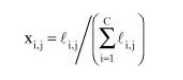

In [ ]:
def x_matriz(lista):
  '''Função que calcula os valores normalizados de vazão por componente em cada estágio -> x (frações molares)'''
  '''lista = array da saída da função de cálculo por Thomas para cada componente do sistema (lista de listas)'''

  n = len(lista) # comprimento da lista -> número de componentes do sistema

  x_componente = [] # vetor que irá abrigar oas frações molares

  for i in lista:
    x_componente.append([]) # criando um local vazio para a fração molar de cada um dos componentes



  # Fazendo um somatório inicial de todos os componentes em cada posição i, será utilizada na divisão e podemos chamar apenas a posição desejada
  divisor = []

  k = 0
  for estagio in lista[0]:
    somatorio = 0

    for componente in lista:
      somatorio += componente[k]

    divisor.append(somatorio) # já validei esse somatório, ele está somando certinho
    k+=1
    # agora temos o valor do dividendo em cada um dos estágios

# Para cada componente puxar o i dele dividindo pelo i do somatório (dentro for item in lista inserir o while)
# logo depois inserir no append (estilo x_componente[k].append(comp), itera com cada componente) o valor do x daquele componente em seu respectivo estágio
  i = 0 # indexação começa em 0 -> itera os estágios
  p = 0 # para iterar o local destino da fração molar de cada um dos componentes ao longo dos estágios

  estagio = len(lista[0]) # apenas resgatando o número de estágios a partir do comprimento da lista do primeiro componente


  for item in lista:

    i=0 # zerando para quando começar um novo componente
    while i < estagio: # o ultimo será estagio - 1 : correta indexação
      x_local = lista[p][i]/divisor[i]

      x_componente[p].append(x_local)

      i +=1
    p +=1

  return(x_componente)




In [ ]:
def y_matriz(K, x_calculado):
  '''Função que calcula y a partir do cálculo prévio de K e de x'''
  '''Aqui, y é calculado por: y = K.x'''
  '''lista = array da saída da função de cálculo por Thomas para cada componente do sistema (lista de listas)'''

  n = len(x_calculado) # comprimento da lista -> número de componentes do sistema

  y_componente = [] # vetor que irá abrigar as frações molares

  for i in x_calculado:
    y_componente.append([]) # criando um local vazio para a fração molar de cada um dos componentes

  i = 0 # indexação começa em 0 -> itera os estágios
  p = 0 # para iterar o local destino da fração molar de cada um dos componentes ao longo dos estágios

  estagio = len(K) # apenas resgatando o número de estágios a partir do comprimento da lista do primeiro componente

  for item in x_calculado:

    i=0 # zerando para quando começar um novo componente
    while i < estagio: # o ultimo será estagio - 1 : correta indexação
      y_local = (x_calculado[p][i])*(K[i][p])

      y_componente[p].append(y_local)

      i +=1
    p +=1

  return(y_componente)

#Inserindo as funções criadas no notebook "T_pb_nid_K_Gamma_Wilson.ipynb" para que possa ser feito o cálculo do ponto de bolha por WILSON

In [ ]:
#Recebe P em BAR
def f_K_Wilson_phi_EOS(x, y, T, P_BAR, a_W, V_m, i_EOS, lista_componentes, dados):
  x = np.array(x) #coloquei isso para pode usar o ".shape"
  nc = x.shape[0]
  # Função para o cálculo do phi
  phi_comp  = f_phi_ELV_EOS(T, P_BAR, y, i_EOS, lista_componentes, dados)['phi']
  # Para o cálculo do gama
  gama_comp = ou3.f_gama_Wilson(x, T, a_W, V_m)
  # Cálculo de P_vap
  Pvap_comp = ou3.f_Pvap_Antoine_vetor_db(T, lista_componentes, dados)
  Pvap_comp_bar = Pvap_comp *(1.0133/760.0)
  # Cálculo do K
  K = np.zeros((nc,))
  for i in range(0,nc):
    K[i] = (Pvap_comp_bar[i]*gama_comp[i])/(P_BAR*phi_comp[i])
  #
  return K

In [ ]:
#Recebe a pressão em BAR
def f_fator_Poynting(T, P_BAR, lista_componentes, dados):
  ''' Calcula o fator de correção de Poynting segundo a Eq. 11.44 p.297
  '''
  nc = len(lista_componentes)
  R_ig = 83.14 # bar*cm3/mol/K
  V_m = ou3.f_Vol_molar_db(lista_componentes, dados)
  Pvap_comp = ou3.f_Pvap_Antoine_vetor_db(T, lista_componentes, dados)*(1.01325/760.0)
  fatPoy = np.zeros((nc,))
  for i in range(0,nc):
    num       = V_m[i]*(P_BAR - Pvap_comp[i])
    den       = R_ig*T
    fatPoy[i] = np.exp(-num/den)
  return fatPoy

In [ ]:
#Recebe a pressão em BAR
def f_phi_ELV_EOS(T, P_BAR, y, i_EOS, lista_componentes, dados):
    #nc   = y.shape[0]
    R_ig = 83.14 # bar*cm3/mol/K
    # Obtendo: Tc, Pc_ omega
    Tc_comp = dados[dados['num'].isin(lista_componentes)]['critical_temp'].to_numpy()
    Pc_comp = dados[dados['num'].isin(lista_componentes)]['critical_pressure'].to_numpy()*(1.0133/1.0)
    om_comp = dados[dados['num'].isin(lista_componentes)]['acentric_factor'].to_numpy()
    #
    resp_EOS     = teq.f_calc_param_EOS_mistura(i_EOS, y, T, P_BAR, Tc_comp,
                                                Pc_comp, om_comp, R_ig)
    param_EOS    = resp_EOS['param_EOS']
    param_cubica = teq.f_conv_param(param_EOS)
    Z_all        = teq.f_raizes_cubica(param_cubica)['x']
    Z_v          = np.max(Z_all)
    a_EOS        = resp_EOS['a_comp']
    b_EOS        = resp_EOS['b_comp']
    phi_chapeu   = teq.f_phi_chapeu_EOS_eq_14_50(Z_v, T, P_BAR, R_ig, a_EOS,
                                                 b_EOS, y, param_EOS)
    #
    phi_sat      = teq.f_phi_sat_comp(T, i_EOS, lista_componentes, dados)
    #
    fatPoy = f_fator_Poynting(T, P_BAR, lista_componentes, dados)
    #
    phi = (phi_chapeu/phi_sat)*fatPoy
    return {'phi': phi, 'phi_chapeu': phi_chapeu, 'phi_sat': phi_sat,
            'fatPoy': fatPoy }

In [ ]:
#Recebe a pressão em BAR
def f_calc_T_Pb_nid_Wilson_EOS_db(z, P_eq_BAR, a_W, V_m, i_EOS, lista_componentes, dados):
  ''' Algoritmo de BOL_T descrito na figura 14.3 p.409 do SVNA
      K calculado utilizando a abordagem gamma/phi com:
      gamma: modelo de Wilson
      phi:   calculado com as equações do capítulo 14 usando a razão
             phi_chapeu/phi_sat
  '''
  z = np.array(z)  #Inseri isso para parar com o erro que estava dando
  nc = z.shape[0]
  # Cálculo do ELV usando Raoult - sistema ideal
  P_eq_mmHg = P_eq_BAR*(760.0/1.01325)
  resp = ou3.f_calculo_PbPo_db('T', P_eq_mmHg, z, lista_componentes, dados)
  T_pb_ideal = resp[0]
  T_pb = T_pb_ideal
  x_eq = z
  y_eq = ou3.f_sol_RR_flash_db(z, P_eq_mmHg, T_pb, lista_componentes, dados)['y_eq']
  # K_comp = ou3.f_K_Raoult_mod_Wilson_01_db(T_pb, P_eq_mmHg, x_eq, y_eq, a_W, V_m,
  #                                      lista_componentes, dados)
  K_comp = f_K_Wilson_phi_EOS(x_eq, y_eq, T_pb, P_eq_BAR, a_W, V_m, i_EOS,
                              lista_componentes, dados)
  # Eq.14.8 do SVNA
  y_eq_novo = K_comp * x_eq
  #phi_comp = ou3.f_phi_gen(y_eq_novo, T_pb, P_eq_mmHg)
  phi_comp = f_phi_ELV_EOS(T_pb, P_eq_BAR, y_eq_novo, i_EOS,      #Usa a Pressão em Bar
                           lista_componentes, dados)['phi']
  gama_comp = ou3.f_gama_Wilson(x_eq, T_pb, a_W, V_m)
  # Componente de referência
  jj = nc - 1
  # Eq. 14.13 do SVNA
  fator = x_eq*gama_comp/phi_comp
  Pvap_comp = ou3.f_Pvap_Antoine_vetor_db(T_pb, lista_componentes, dados)*(1.01325/760.0)
  razao = Pvap_comp/Pvap_comp[jj]
  somat = fator @ razao
  Pvap_novo = P_eq_BAR / somat
  # Eq. 14.15 do SVNA
  T_pb_novo = ou3.f_Teq_Antoine_db(Pvap_novo*(760.0/1.01325),
                                   lista_componentes[jj], dados)[0]
  erro_T = T_pb_novo - T_pb
  # Tolerância para convergência
  epsilon = 1.0e-3
  #
  T_pb = T_pb_novo
  y_eq = y_eq_novo
  k_iter = 1
  n_max_iter = 20
  while ((np.abs(erro_T).mean() > epsilon)&(k_iter < n_max_iter)):
    #print(k_iter, np.abs(erro_T).mean())
    # K_comp = ou3.f_K_Raoult_mod_Wilson_01_db(T_pb, P_eq_mmHg, x_eq, y_eq,
    #                                    a_W, V_m, lista_componentes, dados)
    K_comp = f_K_Wilson_phi_EOS(x_eq, y_eq, T_pb, P_eq_BAR, a_W, V_m, i_EOS,      #Recebe a pressão em BAR
                              lista_componentes, dados)
    y_eq_novo = K_comp * x_eq
    #phi_comp  = ou3.f_phi_gen(y_eq_novo, T_pb, P_eq_mmHg)
    phi_comp = f_phi_ELV_EOS(T_pb, P_eq_BAR, y_eq_novo, i_EOS,        #Recebe a pressão em BAR
                             lista_componentes, dados)['phi']
    gama_comp = ou3.f_gama_Wilson(x_eq, T_pb, a_W, V_m)
    fator     = x_eq*gama_comp/phi_comp
    Pvap_comp = ou3.f_Pvap_Antoine_vetor_db(T_pb, lista_componentes,
                                            dados)*(1.01325/760.0)
    T_pb_novo = np.zeros((nc,))
    #
    for j in range(0,nc):
      razao = Pvap_comp/Pvap_comp[j]
      somat = fator @ razao
      Pvap_novo = P_eq_BAR / somat
      T_pb_novo[j] = ou3.f_Teq_Antoine_db(Pvap_novo*(760.0/1.01325),
                                          lista_componentes[j], dados)[0]
    erro_T = T_pb_novo[jj] - T_pb
    T_pb = T_pb_novo[jj] # T_pb_novo.mean()
    y_eq = y_eq_novo
    k_iter += 1
  #
  return {'T_pb': T_pb, 'y_eq':y_eq, 'erro_T': np.abs(erro_T)}

#Fim das funções criadas no notebook "T_pb_nid_K_Gamma_Wilson.ipynb"

In [ ]:
#Resultado mais ou menos

#Aqui vou inserir os parâmetros necessário para o cálculo do T_pb por WILSON poder ser realizado
#Preciso de um sistema cujos parâmetros de Wilson sejam conhecidos
P_eq  = 760.0     #Pressão de equilírbio em mmHg
nc = np.array(len(z_F))
a_W = np.zeros((nc,nc))
# acetona e água
a_W[1-1,3-1] = 330.0     #1839.45/4.184    Retirado do chemsep
a_W[3-1,1-1] = 1448.01
# metanol e água
a_W[2-1,3-1] = 107.38
a_W[3-1,2-1] = 469.55
# acetona e metanol
a_W[1-1,2-1] = 150.00
a_W[2-1,1-1] = 200.11
#
a_W
V_m = f_Vol_molar_db(lista_componentes, dados)      #Volume molar dos componentes na fase vapor
i_EOS = 3    #Índice do respectivo modelo não ideal para o cálculo de phi (1, 2, 3, 4) = (van de waals, RK, SRK, Peng-Robinson)

In [ ]:
#Ajuste perfeito de T, mas y_acetona e metanol no condensador deixaram a desejar

#Aqui vou inserir os parâmetros necessário para o cálculo do T_pb por WILSON poder ser realizado
#Preciso de um sistema cujos parâmetros de Wilson sejam conhecidos
P_eq  = 760.0     #Pressão de equilírbio em mmHg
nc = np.array(len(z_F))
a_W = np.zeros((nc,nc))
# acetona e água
a_W[1-1,3-1] = 439.6391013384     #1839.45/4.184    Retirado do chemsep
a_W[3-1,1-1] = 1300.489961759082  #5880.57/4.184    Retirado do chemsep
# metanol e água
a_W[2-1,3-1] = 70.38
a_W[3-1,2-1] = 469.55
# acetona e metanol
a_W[1-1,2-1] = 150        # Chute
a_W[2-1,1-1] = 583.11     # Smith van ness
#
a_W
V_m = f_Vol_molar_db(lista_componentes, dados)      #Volume molar dos componentes na fase vapor
i_EOS = 3    #Índice do respectivo modelo não ideal para o cálculo de phi (1, 2, 3, 4) = (van de waals, RK, SRK, Peng-Robinson)

In [ ]:
#MLEHOR RESULTADO ATÉ ENTÃO

#Aqui vou inserir os parâmetros necessário para o cálculo do T_pb por WILSON poder ser realizado
#Preciso de um sistema cujos parâmetros de Wilson sejam conhecidos
P_eq  = 760.0     #Pressão de equilírbio em mmHg
nc = np.array(len(z_F))
a_W = np.zeros((nc,nc))
# acetona e água
a_W[1-1,3-1] = 330.0     #1839.45/4.184    Retirado do chemsep
a_W[3-1,1-1] = 1448.01
# metanol e água
a_W[2-1,3-1] = 107.38
a_W[3-1,2-1] = 469.55
# acetona e metanol
a_W[1-1,2-1] = 150.00
a_W[2-1,1-1] = 450.11 ## Tentando melhorar o metanol ao longo da coluna
#
a_W
V_m = f_Vol_molar_db(lista_componentes, dados)      #Volume molar dos componentes na fase vapor
i_EOS = 3    #Índice do respectivo modelo não ideal para o cálculo de phi (1, 2, 3, 4) = (van de waals, RK, SRK, Peng-Robinson)

#MELHOROU OS VALORES DE Y_ACETONA E METANOL NO CONDENSADOR

#Aqui, na função do loop de temperatura inserir-se-ão os modelos não ideais para os cálculos dos pontos de bolha e volatilidade. Abaixo, constam os modelos e suas respectivas equações descritas em suas propriedades e unidades de medida:

In [ ]:
#Configurei a Loop_T não ideal abaixo para receber a pressão em mmHg e converter internamente
#para BAR nas funções que usam a pressão em BAR

def loop_T(L_chute, V_chute, Tb_old, K_old, n_alim, F, j, D, z, P, lista_componentes, dados, tol_T):
  '''Função que resolve o loop para a convergência de temperatura'''
  '''erro = Tolerância desejada para o desvio entre o calculado e o chute'''
  iteracao = 0 # para verificar depois quantas iterações ele fez
  g = 0 # será atualizado na verificação da tolerância

  while g!=j: # enquanto a verificação de convergencia não bater com a quantida de estágios que devem convergir

  # Garantindo que K_old e T_old vão atualizar após a primeira iteração
    if iteracao == 0:
      K_old_i = K_old
      Tb_old_i = Tb_old # parece que realmente não usei isso kkk pq crio no tb_novo depois
    else:
      K_old_i = K_old_att
      Tb_old_i = Tb_old_att

    # variáveis de todos os componentes dentro de um único vetor

    var_componentes_mtx = []
    k = 0   # Esse k é um contador

    for item in z:
      asp = variavel_matriz_i(k,K_old_i,V_chute,L_chute,n_alim,j,D,F,z)
      var_componentes_mtx.append(asp)
      k += 1

    k = 0 # apenas limpando

      # Algoritmo de Thomas

    var_componentes_mtx_np = np.array(var_componentes_mtx) # colocando em um array numpy como o algoritmo requer

    l_componentes = []

    for item in var_componentes_mtx_np:
      val = TDMA(var_componentes_mtx_np[k][0],var_componentes_mtx_np[k][1],var_componentes_mtx_np[k][2],var_componentes_mtx_np[k][3])
      l_componentes.append(val)
      k+=1

    k = 0

      # Cálculo de x
    x_calculado = x_matriz(l_componentes)

      # Cálculo da nova temperatura

    e = 0 # contador de estágios para a referência na hora de montar o vetor composição
    Tb_novo = [] # mudei de T_new para esse direto por que depois iria referenciar o tb_new de entrada

    for i in x_calculado[0]: # vai iterar em cada um dos estágios

      z_estagio = [] # a cada iteraçao iremos preencher esse z
      compound = 0

      for c in x_calculado:
        z_estagio.append(x_calculado[compound][e])
        compound+=1 # o z está saindo certinho, com somatório = 1 em cada estágio

      #Vou substituir esse cálculo do ponto de bolha ideal pelo ponto de bolha por WILSON
      #Tb = f_calculo_PbPo_db('T', P, z_estagio, lista_componentes, dados) # [a,b] -> composição no estágio analisado
      #Tb = Tb[0] # [0] é ponto de bolha e [1] é o ponto de orvalho

      # Inserindo o cálculo do ponto de bolha pelo modelo de WILSON usando a função
      # desenvolvida no notebook: OU3_K_gamma_phi_NatMendonca.ipynb, nomeada f_calc_T_Pb_nid_Wilson_EOS_db
      # A função do cálculo do ponto de bolha por WILSON já foi definida previamente em uma célula acima
      #
      P_eq_BAR = P*(1.01325/760.0) #A função abaixo trabalha com a pressão em BAR e não mmHg
      Tb = f_calc_T_Pb_nid_Wilson_EOS_db(z_estagio, P_eq_BAR, a_W, V_m, i_EOS, lista_componentes, dados)['T_pb']
      #print('O valor de Tb é: ', Tb)
      Tb_novo.append(Tb)
      e +=1

      # Cálculo do novo valor de K
    K_novo = []

    for i in Tb_novo:
      #Trocando o K de Raoult pelo K não ideal de WILSON
      #K = (f_K_Raoult_db(i,P,lista_componentes,dados)) # i é a própria temperatura de equilíbrio
      y = f_calc_T_Pb_nid_Wilson_EOS_db(z_estagio, P_eq_BAR, a_W, V_m, i_EOS, lista_componentes, dados)['y_eq']
      #A função abaixo usa a pressão em BAR
      K = f_K_Wilson_phi_EOS(z_estagio, y, i, P_eq_BAR, a_W, V_m, i_EOS, lista_componentes, dados)
      K_novo.append(K)

      # Cálculo de y:
    y_calculado = y_matriz(K_novo, x_calculado)

      # Cálculo da convergência de temperatura:
    Dif_T = abs(np.array(Tb_novo) - np.array(Tb_old_i))
    result = Dif_T < tol_T # array que retorna True ou False para a condição de ser menor que a tolerância

    for i in result:
      if i ==False:
        g += 0
      if i ==True:
        g+=1

    if g!=j:
      g = 0  # Para limpar ele para uma nova iteração

    #tb_old_att = Tb_old_i + (Tb_novo - Tb_old_i)

    Tb_old_att = Tb_novo # atualizando o valor para a nova iteração
    K_old_att = K_novo   # atualizando o valor para a nova iteração

    iteracao +=1 # atualizando o contador de loops realizados

  Tb_final = Tb_old_att # retorna o último valor atualizado
  K_final = K_old_att

  return iteracao, Tb_final, K_final, x_calculado, y_calculado, Dif_T, result

###Cálculo de entalpia

Criando uma função baseada na função (f_gera_dados_diag_H_ps(P_eq, npg, lista_componentes,dados)) da contribuição do método de Ponchon-Savarit, mas inserindo os valores de T, x e y encontrados anteriormente

# Aqui, no cálculo de entalpia, inserir-se-ão os modelos para o cálculo da entalpia de vaporização pelos modelos não ideais listados abaixo com suas propriedades e unidades de medida.



In [ ]:
def f_gera_dados_H(P_eq, j, lista_componentes,dados,x_converg,y_converg,T_converg,componente_prov): # componente: dizer se é do [0] ou [1] -> tanto faz, se der certo eu tiro essa variável
    '''Função que gera o dataframe com os dados para a serem utilizados nos cálculos dos componentes da matriz de BEG
        Entrada:
        P_eq = pressão de equilíbrio em mmHg
        npg = quantidade de pontos gerados -> será o nosso j
        lista_componentes =
        dados =
        Saida:
        dados_ps = dataframe com os dados para calcular as variáveis da matriz tridiagonal para aplicar o método de Thomas
    '''
    dados_ps = pd.DataFrame((T_converg, x_converg[componente_prov],y_converg[componente_prov]),index=['T','x','y']).T # apenas inserindo as temperaturas dos estágios
    dados_ps

    DH_vap_vet = []

    for i, row in dados_ps.iterrows():

        DH_vap_vet.append(f_DHvap_Watson_db(row['T'], lista_componentes, dados)) # Cálculo da Entalpia de vaporização de todos os componentes em cada um dos níveis


    # Inserindo uma rotina para criar um vetor com os y de cada componente ao longo dos estágios

    y_estagio = [] # a cada iteraçao iremos preencher esse y
    compound = 0

    for item in y_converg[0]:
      y_estagio.append([]) # criando listas de listas para serem preenchidas em seguida

    componente = 0
    stg = 0

    for c in y_converg: # para cada um dos componentes
      stg = 0 # para limpar para um novo componente
      for estagio in y_converg[0]:
        y_estagio[stg].append(y_converg[componente][stg])
        stg +=1
      componente +=1

    DH_vap = [] # lista a ser preenchida
    it = 0
    for iten in y_converg[0]: # iterando em cada estágio
      DH_vap.append(y_estagio[it] @ DH_vap_vet[it]) # vai calcular tudo de uma vez para cada estágio -> conferi e está correto
      it+=1

    Hig_v = [] # calculando a entalpia da corrente de vapor em cada um dos estágios
    temperatura_i = 0
    for ite in y_estagio:
      Hig_v.append(f_H_vap_ig_stream(ite, 273.15,T_converg[temperatura_i], lista_componentes, dados)[0]) # só isso que eu não verifiquei -> troquei y_estagio pelo ite
      temperatura_i +=1

    dados_ps['DH_vap_Watson'] = DH_vap
    dados_ps['Hig_v'] = Hig_v
    dados_ps['Hig_l'] = dados_ps['Hig_v'] - dados_ps['DH_vap_Watson']

    return dados_ps

In [ ]:
def variavel_matriz_i_BEG(H_i, Q1, QN, n_aliment, j, vaz_D, vaz_B, F, hf):
  '''n_aliment = estágio de alimentação, j é o número de estágios(contando com o reboiler)
  vaz_D = D -> por que tem o D vazão e o D lista a ser preenchida
  H_i é a tabela contendo os dados de entalpia do componente desejado'''
  #
  B = []
  C = []
  D = []

  # J = 1 -> condensador total
  B.append(0)
  C.append(H_i['HL'][0] - H_i['HV'][1])
  D.append(Q1) # não tem alimentação no condensador -> F*zi

  # J = 2 até a alimentação
  #lim_sup = n_aliment - 1 # por causa da indexação em python começar em 0, vai parar no
  lim_sup = n_aliment
  u = 1 # corresponde ao segundo estágio, j = 2 (topo da coluna)

  while u<lim_sup: # irá preencher os estágio até a alimentação
    B.append(H_i['HV'][u] - H_i['HL'][u-1])
    C.append(H_i['HL'][u] - H_i['HV'][u+1])
    D.append(0 + 0 + vaz_D*(H_i['HL'][u-1]) - vaz_D*(H_i['HL'][u])) #- F*H_i['Hig_l'][u] + F*H_i['Hig_l'][u-1])
    u += 1

  # J = alimentação
  B.append(H_i['HV'][lim_sup] - H_i['HL'][lim_sup-1])
  C.append(H_i['HL'][lim_sup] - H_i['HV'][lim_sup+1])
  D.append(F*hf + 0 + vaz_D*(H_i['HL'][lim_sup-1]) - vaz_D*(H_i['HL'][lim_sup]) - F*(H_i['HL'][lim_sup])) #+ F*H_i['HL'][n_alim-1])
  #D.append(F*hf + 0 + vaz_D*(H_i['HL'][lim_sup-1]) - vaz_D*(H_i['HL'][lim_sup]) + F*(H_i['HL'][lim_sup])*fv_flash) #+ F*H_i['HL'][n_alim-1])

  # J = alimentação até o reboiler
  v = n_aliment + 1

  while v<(j-1): # irá preencher após o estágio de alimentação e antes do reboiler
    B.append(H_i['HV'][v] - H_i['HL'][v-1])
    C.append(H_i['HL'][v] - H_i['HV'][v+1])
    D.append(0 + 0 + vaz_D*(H_i['HL'][v-1]) - vaz_D*(H_i['HL'][v]) - F*(H_i['HL'][v]) + F*(H_i['HL'][v-1]) )  # k é o componente todo

    v += 1

  # Reboiler
  B.append(H_i['HV'][j-1] - H_i['HV'][j-2]) # j-1 devido a indexação
  C.append(0)
  D.append(0 + QN + vaz_B*(H_i['HL'][j-2]) - vaz_B*(H_i['HL'][j-1]) - 0) # não tem alimentação no reboiler

  B[-1] = - C[-2]

  return B, C, D

In [ ]:
def it2(var, j):
  '''Função que calcula V por cascateamento'''
  Bi = var[0]
  Ci = var[1]
  Di = var[2]

  V = [] # lista contendo o resultado

  #V.append(0) # a primeira vazão é nula
  V.append(D) # a primeira vazão é nula -> inseri D pq ela vira o destilado
  V.append(Di[0]/Ci[0]) # a segunda vazão é essa

  # para o resto até N-1
  u=1 # posição inicial a ser avaliada

  while u<(j-1): # Vai calcular tudo
    gu = ( Di[u] - (Bi[u])*(V[u]) )/(Ci[u])
    V.append(gu)
    u+=1

  #V.pop(-1)

  d = np.array((V))

  return d

In [ ]:
def loop_vaz(L_calc, V_calc, Tb_old, k_old, n_alim, F, j, D, z, P, lista_componentes, dados, erroT, erroV, erroL, hf, q, R_D):
  '''Função loop para a convergência de V e L
  Tb_old e k_old são os valores obtidos na primeira convergência
  L_calc e V_calc são os valores obtidos na 1º resolução de matriz'''
  iteracao = 0 # para verificar depois quantas iterações ele fez
  g = 0 # será atualizado na verificação da tolerância de L
  h = 0 # será atualizado na verificação da tolerância de V

  while g!=j and h!=j: # enquanto a verificação de convergencia não bater com a quantida de estágios que devem convergir

    # Grantindo que D vão atualizar após a primeira iteração

    if iteracao == 0:
      D_i = D
      V_calc_i = V_calc
      L_calc_i = L_calc
      k_old_i = k_old
      Tb_old_i = Tb_old
      #hf_i = hf

    else:
      D_i = D_att
      V_calc_i = V_calc_att
      L_calc_i = L_calc_att
      k_old_i = k_old_att
      Tb_old_i = Tb_old_att
      #hf_i = hf_att

    # Calculando novos valores de T,X e Y a partir de L e V calculados anteriormente, sendo este o novo chute
    sol_T = loop_T(L_calc_i,V_calc_i,Tb_old_i,k_old_i,n_alim,F,j,D_i,z,P,lista_componentes,dados,erroT)

    # Recuperando os valores desejados de T, x e y
    T_new = sol_T[1]
    x_new = sol_T[3]
    y_new = sol_T[4]
    erro_T = sol_T[5]
    k_new = sol_T[2]


    B_att = F - D
    D_att = D


    H_componentes = f_gera_dados_H(P,j,lista_componentes,dados,x_new,y_new,T_new,0) # o 0 é apenas para indicar um componente para puxar x e y

    H_tot = pd.DataFrame((H_componentes['T'],H_componentes['Hig_v'],H_componentes['Hig_l']),index = ['T','HV','HL']).T


    # Carga térmica do condensador e do refervedor

    hd = H_tot['HL'][0] # entalpias líquidas no condensador [0]
    H2 = H_tot['HV'][1] # entalpias líquidas no topo da coluna [1]
    Q1 = D_att*(1 + R_D)*(hd - H2) # já tem o valor atualizado

    hb = H_tot['HL'][j-1] # entalpias líquidas da corrente de saída do reboiler
    somat = F*hf
    QN = D_att*hd + B_att*hb - somat - Q1
    print(Q1)
    print(QN)

    # Calculando variáveis da matriz
    var_BEG = variavel_matriz_i_BEG(H_tot,Q1,QN,n_alim,j,D_att,B_att,F,hf)

    V_calc_att = it2(var_BEG,j)

    # Obtendo L
    L_calc_att = f_L_inicial(D_att, B_att, n_alim, V_calc_att, F, j)

      # Cálculo da convergência de V e L:
    Dif_L = abs(L_calc_att - L_calc_i)/L_calc_att
    result_L = Dif_L<erroL # array que retorna True ou False para a condição de ser menor que a tolerância

    Dif_V = abs(V_calc_att - V_calc_i)/V_calc_att
    result_V = Dif_V<erroV

    for i in result_L: # verificando para L
      if i ==False:
        g += 0
      if i ==True:
        g+=1

    if g!=j:
      g = 0  # Para limpar ele para uma nova iteração

    for i in result_V: # verificando para V
      if i ==False:
        h += 0
      if i ==True:
        h+=1

    if h!=j:
      h = 0  # Para limpar ele para uma nova iteração

    Tb_old_att = T_new # atualizando o valor para a nova iteração
    k_old_att = k_new  # atualizando o valor para a nova iteração
    iteracao +=1 # atualizando o contador de loops realizados
    print(iteracao)

    #print(Tb_old_att[0])

  Tb_final = Tb_old_att
  k_final = k_old_att
  L_final = L_calc_att
  V_final = V_calc_att
  x_final = x_new
  y_final = y_new

  return iteracao,Tb_final,L_final,V_final,x_final,y_final,k_final,Dif_V,Dif_L


#Fim das funções que devem ser definidas previamente ao uso do simulador.

In [ ]:
# Inserindo uma lista com os nomes dos componentes para que o
# simulador gere os gráficos e etc de acordo com o nome deles, automaticamente
nome_componente = ['acetona', 'metanol','água']

In [ ]:
def f_sim_DestFrac_Thomas_nid(par_coluna, lista_componentes, nome_componente):
  # Variáveis internas correrspondentes aos parâmetros
  F = par_coluna['n_F']         # 100  mol/s -  Vazão molar da alimentação
  z = par_coluna['z_F']         # [Acetona, metanol, água]
  P = par_coluna['P']           # 760 mmHg
  Ti = par_coluna['T_F']        # 360 K
  n = par_coluna['netc']        # 10
  n_alim = par_coluna['j_alim'] # 5 estágio em relação somente à coluna, sem considerar condensador e refervedor (sempre 1 a menos em relação ao ChemSep)
  raz = par_coluna['R_D']       # 2 - Razão de refluxo
  #
  D = par_coluna['D']           # Vazão do destilado de topo (ARBITRADO)
  B = par_coluna['B']           # Vazão do destilado de fundo (ARBITRADO)
  #
  nets = netc + 2 #Somando o Reboiler e o condensador
  j = nets
  nc = len(lista_componentes)
  # Calculo da volatilidade para determinação do chave leve e chave pesado
  #K_comp_F = f_K_Raoult_db(Ti, P, lista_componentes, dados)[0]
  P_eq_BAR = P*(1.01325/760.0) #Convertendo para BAR para usar nas funções de não idealidade
  y = f_calc_T_Pb_nid_Wilson_EOS_db(z, P_eq_BAR, a_W, V_m, i_EOS, lista_componentes, dados)['y_eq']
  T = Ti
  #A função abaixo usa a pressão em mmHg e não em BAR
  K_comp_F = f_K_Wilson_phi_EOS(z, y, T, P_eq_BAR, a_W, V_m, i_EOS, lista_componentes, dados)
  i_chk = K_comp_F.argmin() # componente chave pesado
  i_clk = K_comp_F.argmax() # componente chave leve
  i_leve = i_clk            #Ela chama de i_leve a posição do componente chave leve, em vez de i_clk
  #
  #Cálculo do flash e da qualidade da carga
  flash = f_sol_RR_flash_db(z, P, Ti, lista_componentes, dados)
  fv_flash = flash['fv_flash']
  print('fração vaporizada no flash: ', fv_flash)
  Lf = F - (fv_flash*F)
  Vf = F - Lf
  q = Lf/F            #Pode-se escrever a qualidade da carga, simplesmente, como sendo: q = (1 - fv)
  #
  # Chute inicial para as vazões e temperaturas:
  # Considerações do chute:
  # 1) Componente mais leve sai todo no topo e o mais pesado todo no fundo
  # 2) Em relação ao restante dos componentes, iremos tomar 1 como parâmetro. Se for maior que 1 irá para o topo e se for menor, irá para o fundo.
  # Procedimento:
  # Vazões de líquido e vapor na seção de retificação:
  L = raz*D # mol/s
  V = L + D # mol/s
  # Valores na alimentação
  L_alim = L + q*F
  V_alim = V - (1-q)*F
  #Vamos manter o chute dessa forma
  #
  # Esse vetor deverá ser criado com o número de estágios + condensador e refervedor, de forma que o primeiro item do vetor seja 0 pois no condensador não existe vapor
  V_chute = [0] # já começando com o valor inicial certinho
  k = 0
  while k < n_alim: # vai fazer o preenchimento até chegar na alimentação
    V_chute.append(V_alim)
    k +=1
  while k != j-1: # vai fazer o preenchimento até chegar o final, partindo da alimentação
    V_chute.append(V)
    k +=1
  k=0 # apenas limpando o k por que eu uso muito e por um descuido ele pode entrar com valor depois
  V_chute
  # Calculando o chute dos valores de L pela função definida previamente:
  L_chute = f_L_inicial(D, B, n_alim, V_chute, F, j)
  # Temperaturas e K
  # Considerações:Um melhor chute inicial pode ser obtido ao estimar as composições no destilado e no fundo e fazer cálculos de ponto de bolha para ambos.
  # Então assumir que a temperatura varia linearmente de estágio para estágio.
  # Será necessário criar um Z_topo e um Z_fundo de acordo com a divisao feita para a corrente de B e D
  z_topo = []
  z_fundo = []
  # Irei fazer uma verificação em cada um dos itens da lista para inserir corretamente o chave leve no topo, o pesado no fundo e os outros nos locais baseado no k> ou <1
  k = 0
  gu = len(z)
  z_num = list(range(0, gu, 1))

  for i in z_num:

    if i == i_chk:
      z_topo.append(0)
      z_fundo.append(1)

    elif i == i_leve:
      z_topo.append(1)
      z_fundo.append(0)

    elif K_comp_F[k] > 1:
      z_fundo.append(0)
      z_topo.append(1)

    else:
      z_fundo.append(1)
      z_topo.append(0)

    k += 1
  k = 0 # limpando ele
  # Ponto de bolha no topo da coluna
  # INSERINDO O BOLHA_T NÃO IDEAL
  #Tb1 = f_calculo_PbPo_db('T', P, z_topo, lista_componentes, dados) # [1,0] -> composição estimada no topo da coluna [Benzeno,Tolueno] no chute inicial para CMO
  #Tive que corrigir a pressão para BAR na linha abaixo
  Tb1 = f_calc_T_Pb_nid_Wilson_EOS_db(z_topo, P_eq_BAR, a_W, V_m, i_EOS, lista_componentes, dados)['T_pb']
  #Tb1 = Tb1[0] #Não precisa do índice[0]
  # Ponto de bolha no fundo da coluna
  #TbN = f_calculo_PbPo_db('T', P, z_fundo, lista_componentes, dados) # [0,1] -> composição estimada no topo da coluna no chute inicial para CMO
  #Tive que corrigir a pressão para BAR na linha abaixo
  TbN = f_calc_T_Pb_nid_Wilson_EOS_db(z_fundo, P_eq_BAR, a_W, V_m, i_EOS, lista_componentes, dados)['T_pb']
  #TbN = TbN[0]   #Não precisa do índice[0]
  # Ponto de bolha na alimentação
  #Tb_alim = f_calculo_PbPo_db('T', P, z, lista_componentes, dados) # composição da alimentação
  Tb_alim = f_calc_T_Pb_nid_Wilson_EOS_db(z, P_eq_BAR, a_W, V_m, i_EOS, lista_componentes, dados)['T_pb']
  #Tb_alim = Tb_alim[0] #Não precisa do índice[0]
  # Considerando que a temperatura varia linearmente a partir do estágio de alimentação
  T_chute_pt1 = np.linspace(Tb1, Tb_alim, n_alim) # j = n+1 = 13 + 1 = 14 -> o 1 a mais é o reboiler
  T_chute_pt2 = np.linspace(Tb_alim,TbN,j-n_alim+1) #
  T_chute_pt2 = T_chute_pt2[1:]
  T_chute = np.concatenate((T_chute_pt1,T_chute_pt2))
  # Chute para as volatilidades (K)
  K_chute = []
  #print(T_chute)
  for i in T_chute:
    #K = (f_K_Raoult_db(i, P, lista_componentes, dados)) # i é a própria temperatura de equilíbrio
    #K = (f_K_Wilson_phi_EOS(x, y, i, P, a_W, V_m, i_EOS, lista_componentes, dados))
    K = (f_K_Wilson_phi_EOS(z, y, i, P_eq_BAR, a_W, V_m, i_EOS, lista_componentes, dados))   #Testando mudança pra eliminar erro
    K_chute.append(K) # retorna k (dos dois componentes)
  #
  # Variáveis para a matriz - Loop para cada um dos componentes
  var_componentes_mtx = []
  k = 0 #Esse k é um contador e não a volatilidade
  #print(K_chute)
  for item in z:
    asp = variavel_matriz_i(k, K_chute, V_chute, L_chute, n_alim, j, D, F, z)
    var_componentes_mtx.append(asp)
    k += 1

  k = 0 # Apenas limpando a variável
  var_componentes_mtx_np = np.array(var_componentes_mtx)
  # Aplicando o algoritmo de Thomas em cada um dos componentes e armazenando em um único array
  l_componentes = []
  k = 0
  for item in var_componentes_mtx_np:
    val = TDMA(var_componentes_mtx_np[k][0],var_componentes_mtx_np[k][1],var_componentes_mtx_np[k][2],var_componentes_mtx_np[k][3])
    l_componentes.append(val)
    k+=1

  k = 0 #Limpando a variável
  #Verificando o formato do primeiro componente da lista lá na saída
  #
  # Cálculo dos valores normalizados de vazão por componente em cada estágio -> x (Frações molares)
  x_calculado = x_matriz(l_componentes) # Condensador -> reboiler
  # Verificando se o somatório das frações molares
  k=0 # representa o componente (contador de componentes?)
  for estagio in x_calculado[0]:
    somat_x = 0
    for component in x_calculado:
      somat_x += component[k]
    k+=1
  # Verifique se os somatórios das frações molares dera iguais a 1
  #
  # Cálculo da temperatura em cada estágio a partir do cálculo do ponto de bolha
  # Ponto de bolha em cada estágio
  e = 0 # contador de estágios para a referência na hora de montar o vetor composição
  Tb_new = []
  for i in x_calculado[0]: # vai iterar em cada um dos estágios
    z_estagio = [] # a cada iteraçao iremos preencher esse z
    compound = 0
    for c in x_calculado:
      z_estagio.append(x_calculado[compound][e])
      compound+=1 # o z está saindo certinho, com somatório =1 em cada estágio
    #Tb = f_calculo_PbPo_db('T',P,z_estagio,lista_componentes,dados) # [a,b] -> composição no estágio analisado
    #Tb = Tb[0] # [0] é ponto de bolha e [1] é o ponto de orvalho
    #Inserindo o Tb NÃO IDEAL
    Tb = f_calc_T_Pb_nid_Wilson_EOS_db(z_estagio, P_eq_BAR, a_W, V_m, i_EOS, lista_componentes, dados)['T_pb']
    Tb_new.append(Tb)
    e +=1
  #OBS: A temperatura no estágio de alimentação realmente vai variar ao longo das iterações
  # Calculando o novo valor de K
  K_new = []
  for Tb in Tb_new:
    #K_prov = (f_K_Raoult_db(Tb, P, lista_componentes, dados)) # Tb é a própria temperatura de equilíbrio
    #Inserindo o K_prov NÃO IDEAL
    y = f_calc_T_Pb_nid_Wilson_EOS_db(z_estagio, P_eq_BAR, a_W, V_m, i_EOS, lista_componentes, dados)['y_eq']
    K_prov = (f_K_Wilson_phi_EOS(z_estagio, y, Tb, P_eq_BAR, a_W, V_m, i_EOS, lista_componentes, dados)) # Tb é a própria temperatura de equilíbrio
    #K_new.append(K_prov[0]) # retorna K (dos dois componentes) e P_vap
                            # K[0] para retirar apenas a parte da resposta do K, K[1] = P_vap
    K_new.append(K_prov)
  # Calculando y: (y = K.x)
  y_calculado = y_matriz(K_new, x_calculado)
  # Verificando se o somatório de y é igual a 1
  k=0 # representa o componente
  for estag in y_calculado[0]:
    somat_y = 0
    for component in y_calculado:
      somat_y += component[k]
    k+=1
  # Verifique se os somatórios das frações molares dera iguais a 1
  #
  # Cálculo do erroentre o chute inicial e o T calculado -> Critério de parada
  # |T_j,new - T_j,old| < tol_T
  tol_T = 10**(-2) # Valor recomendado pelo livro
  Dif_T = abs(Tb_new - T_chute)
  # Inserindo o Loop para a convergência de temperatura (função definida previamente)
  # Resolvendo o loop para encontrar T, x e y
  sol_T = loop_T(L_chute, V_chute, Tb_new, K_new, n_alim, F, j, D, z, P, lista_componentes, dados, tol_T)
  #Perfil de temperatura
  T_converg = sol_T[1]
  # x em cada estágio
  x_converg = sol_T[3]
  # y em cada estágio
  # Gráfico da fração molar de líquido na torre de destilação
  y_converg = sol_T[4]
  x_eixo = ['condensador','2-Topo','3','4','5','6','feed','8','9','10','11','Reboiler']
  fig15, ax15 = plt.subplots(figsize =(9,5))
  ax15.plot( x_converg[0],x_eixo, 'r', label='x_acetona')
  ax15.plot( x_converg[1],x_eixo, 'g', label='x_metanol')
  ax15.plot( x_converg[2],x_eixo, 'b', label='x_água')
  # Adicionando texto nos eixos - descrição
  ax15.set_ylabel('x')
  ax15.invert_yaxis()
  # Adicionando título para a figura
  ax15.set_title('Fração molar de líquido na torre de destilação')
  ax15.legend()
  #
  # Balanço de energia na forma matricial.
  # Objetivo: Corrigir os valores de V e L a partir da conversão (?) de T, x e y
  # Abaixo temos um sistema composto por um balanço global
  # Cálculo de Entalpia
  # Criando um DataFrame com a entalpia das correntes L e V em cda nível (nível = estágio?)
  # Será a soma da entalpia de todos os componentes em cada nível separada em L e V
  # De forma provisória seguiremos como se ela já fosse o total
  # print(T_converg)
  H_componentes = f_gera_dados_H(P, j, lista_componentes, dados, x_converg, y_converg, T_converg, 0) # o 0 é apenas para indicar um componente para puxar x e y
  #Pegando apenas os dados de interesse
  H_tot = pd.DataFrame((H_componentes['T'],H_componentes['Hig_v'],H_componentes['Hig_l']),index = ['T','HV','HL']).T
  # Cálculo da entalpia da corrente de entrada - hF
  # Calculando da forma mostrada pelo Torres, usando a entalpia da carga em si e não levando em consideração após o flash
  # Necessário calcular 2 coisas:
  # 1) Entalpia do vapor saturado na temperatura da carga, utilizando as frações molares obtidas no flash
  # 2) Entalpia do líquido saturado na temperatura da carga, utilizando as frações molares obtidas no flash
  # Cálculo da entalpia de vaporização de todos os componentes na temperatura do flash
  H_vap_flash_NC = f_DHvap_Watson_db(Ti, lista_componentes, dados)
  # Cálculo da entalpia de vaporização da corrente como um todo
  H_vap_corrente_flash = flash['y_eq'] @ H_vap_flash_NC
  # Cálculo da entalpia da corrente de vapor
  H_vap_flash = f_H_vap_ig_stream(flash['y_eq'], 273.15, Ti , lista_componentes, dados)[0]
  #Cálculo da entalpia da corrente de líquido
  H_liq_flash = H_vap_flash - H_vap_corrente_flash
  #Finalmente, o cálculo da entalpia da carga de alimentação
  hF = -q*(H_vap_flash - H_liq_flash) + H_vap_flash
  # Carga térmica do condensador e do refervedor
  # Entalpia da corrente líquida (benzeno + tolueno) no destilado -> condensador
  hd = H_tot['HL'][0] # entalpias líquidas no condensador [0]
  # Entalpia da corrente gasosa (benzeno + tolueno) no topo da coluna
  H2 = H_tot['HV'][1] # entalpias líquidas no topo da coluna [1]
  # Finalmente, a carga térmica
  Q1 = D*(1+raz)*(hd - H2) # já vem com o valor atualizado de D ao invés de usar V antigo
  # Refervedor:
  # Entalpia da corrente líquida (benzeno + tolueno) no fundo
  hb = H_tot['HL'][j-1] # entalpias líquidas da corrente de saída do reboiler
  # Somatório, onde k é o prato onde entra alguma corrente e hF é a entalpia do líquido nessa corrente
  somat = F*hF
  # Finalmente, a carga térmica do refervedor
  QN = D*hd + B*hb - somat - Q1 # já atualiza os valores
  # Cálculo das variáveis B, C e D para cada componente -> Referente ao BEG
  vaz_D = D #
  vaz_B = B #
  var_BEG = variavel_matriz_i_BEG(H_tot, Q1, QN, n_alim, j, vaz_D, vaz_B, F, hF)
  # Cálculo de V
  # (O método de Thomas não é aplicável visto que Aj = 0)
  # Definiu-se previamente uma função para calcular V por cascateamento
  # Como V2 é conhecido, BE1 = 0, vamos usar ele para descobrir V3 e assim por diante
  V_calc_pinv = it2(var_BEG, j)
  # Cálculo de L a partir de V
  # Usando a função para calcular L a partir de um chute de V seguindo um fluxo molar constante (apenas para o chute)
  L_calc = f_L_inicial(D, B, n_alim, V_calc_pinv, F, j) # aqui era B_att e D_att
  # Erro entre o chute inicial de V/L e o calculado -> Critério de parada
  tol_L = 10**(-4) # Valor recomendado pelo livro
  tol_V = 10**(-4) # Valor recomendado pelo livro
  Dif_L = abs(L_calc - L_chute)
  Dif_V = abs(V_calc_pinv - V_chute)
  # Inserindo o Loop para a convergência de V e L
  # Resolvendo o Loop para encontrar V e L, além dos valores de T, x e y
  k_converg = sol_T[2]
  sol_V = loop_vaz(L_calc, V_calc_pinv, T_converg, k_converg, n_alim, F, j, vaz_D, z, P, lista_componentes, dados, tol_T, tol_V, tol_L, hF, q, raz) # L_calc
  sol_V[0] # Número de iterações utilizadas
  sol_V[7] # Erro encontrado para V
  sol_V[8] # Erro encontrado para L
  # Perfil de temperatura
  T_final = sol_V[1]
  # x em cada estágio
  x_final = sol_V[4]
  # y em cada estágio
  y_final = sol_V[5]
  # V em cada estágio
  V_final = sol_V[3]
  # L em cada estágio
  L_final = sol_V[2]
  ###########################################
  # Itens auxiliares dos gráficos e tabelas:
  # Nomes das colunas do DataFrame e eixo x dos gráficos
  # É necessário criar o nome das colunas de forma automática para esteas serem inseridas no DataFrame final,
  # de forma que contenha também o estágio da alimentação
  #
  colunas = []

  colunas.append('condensador')
  colunas.append('2-topo')

  rotulo = 3 # o primeiro que será incluído, a menos que ele seja a alimentação

  while rotulo < n_alim+1: # pegando cada um dos estágios
    colunas.append(rotulo)
    rotulo += 1

  colunas.append('alimentação')
  rotulo += 1

  while rotulo < j-1: # pegando cada um dos estágios
    colunas.append(rotulo)
    rotulo += 1

  colunas.append('fundo')
  colunas.append('refervedor')
  #
  # Index do DataFrame
  #
  linhas = []
  for i in nome_componente:
    a = 'x_' + i
    linhas.append(a)
  for i in nome_componente:
    a = 'y_' + i
    linhas.append(a)
  linhas.append('V [kg/s]')
  linhas.append('L [kg/s]')
  linhas.append('T [K]')
  # Vetor com os dados do DataFrame:
  # Criando o vetor que contém x, y, V, L e T
  vetor_dados = []
  n_componentes = len(x_final)
  # fazer um append geral de tudo
  cont = 0
  while cont != n_componentes:
    vetor_dados.append(x_final[cont]) # inserindo x
    cont +=1
  cont = 0
  while cont != n_componentes:
    vetor_dados.append(y_final[cont]) # inserindo y
    cont +=1
  vetor_dados.append(V_final) # inserindo vazão de vapor
  vetor_dados.append(L_final) # inserindo vazão de líquido
  vetor_dados.append(T_final) # inserindo temperatura
  # Geração do DataFrame com os dados finais
  Resultado_final = pd.DataFrame(vetor_dados, columns=colunas,index=linhas)
  #
  #Cálculo dos valores finais de D e B a partir do valor final de x e y
  x1D_final = x_final[0][0]       # valor no topo
  x1B_final = x_final[0][j-1]     # valor complementar ao topo
  v_resul_final = np.array([z[0]*F,F])
  A_bmg_final = np.array([[x1B_final,x1D_final],
                    [1,1]])
  x_sol_bmg_final = np.linalg.inv(A_bmg_final) @ v_resul_final
  B_final = x_sol_bmg_final[0]
  D_final = x_sol_bmg_final[1]
  #Gráficos
  x_eixo = colunas
  #Fração molar de líquido na torre de destilação
  # Fazendo o gráfico
  fig9, ax9 = plt.subplots(figsize =(10,6))
  fg = 0
  while fg != n_componentes:
    ax9.plot( x_final[fg],x_eixo, label='x_' + nome_componente[fg])
    fg+=1
  # Adicionando texto nos eixos - descrição
  ax9.set_ylabel('x')
  ax9.invert_yaxis()
  # Adicionando título para a figura
  ax9.set_title('Fração molar de líquido na torre de destilação')
  # Adicionando uma legenda
  ax9.legend()
  #
  # Fração molar de vapor na torre de destilação
  # Fazendo o gráfico
  fig91, ax91 = plt.subplots(figsize =(10,6))
  fg = 0
  while fg != n_componentes:
    ax91.plot( y_final[fg],x_eixo, label='y_' + nome_componente[fg])
    fg+=1
  # Adicionando texto nos eixos - descrição
  ax91.set_ylabel('y')
  ax91.invert_yaxis()
  # Adicionando título para a figura
  ax91.set_title('Fração molar de vapor na torre de destilação')
  # Adicionando uma legenda
  ax91.legend()
  #
  # Vazões
  fig3, ax3 = plt.subplots(figsize =(13,4))
  ax3.plot( x_eixo,V_final, 'g', label='Vapor')
  ax3.plot( x_eixo,L_final, 'm', label='Líquido')

  # Adicionando texto nos eixos - descrição
  ax3.set_ylabel('vazão [kmol/s]')
  # Adicionando título para a figura
  ax3.set_title('Vazão das correntes de líquido e vapor ao longo do sistema')
  # Adicionando uma legenda
  ax3.legend()
  #
  #Perfil de Temperatura
  fig4, ax4 = plt.subplots(figsize =(13,4))
  #print('Valores de T_final: ', T_final)
  ax4.plot(x_eixo,T_final, 'y',label="Simulado")

  # Adicionando texto nos eixos - descrição
  ax4.set_ylabel('Temperatura [K]')
  # Adicionando título para a figura
  ax4.set_title('Temperatura ao longo do sistema')

  # Adicionando uma legenda
  ax4.legend()




  #
  saida = {'nets': nets, 'K_comp_F': K_comp_F, 'D': D, 'B': B, 'flash': flash, 'q':q,
           'V_chute': V_chute, 'L_chute':L_chute, 'z_topo': z_topo, 'z_fundo': z_fundo,
           'Pb_topo': Tb1, 'Pb_fundo': TbN, 'Pb_alim':Tb_alim, 'T_chute:': T_chute, 'K_chute': K_chute,
           'var_componentes_mtx_prévia': var_componentes_mtx[0], 'l_componentes_prévia': l_componentes[0],
           'x_calculado': x_calculado, 'somatorio_fracoes_x': somat_x, 'Tpb_calculado':Tb_new, 'K_calculado': K_new,
           'y_calculado':y_calculado, 'somatorio_fracoes_y': somat_y, 'Dif_T_chute_T_calc': Dif_T, 'n_iteracoes': sol_T[0],
           'erro_encontrado': sol_T[5], 'tol_desejada_ok?': sol_T[6], 'T_converg': T_converg, 'x_converg':x_converg,
           'y_converg': y_converg, 'H_componentes': H_componentes, 'H_tot': H_tot, 'H_vap_flash_NC': H_vap_flash_NC, 'H_vap_corrente_flash': H_vap_corrente_flash,
           'H_vap_flash': H_vap_flash,'H_liq_flash': H_liq_flash, 'entalpia da carga (hF)': hF, 'hd': hd, 'H2': H2, 'carga_term_cond': Q1,
           'somat': somat, 'QN': QN, 'var_BEG': var_BEG, 'V_calc_pinv': V_calc_pinv, 'L_calc': L_calc, 'Dif_L': Dif_L, 'Dif_V': Dif_V, 'k_converg': k_converg,
           'sol_V': sol_V, 'n_iterac_sol_V': sol_V[0], 'erro_V': sol_V[7], 'erro_L': sol_V[8], 'Perfil_de_T_final': T_final, 'x_cada_estagio': x_final,
           'y_cada_estagio': y_final, 'V_cada_estagio': V_final, 'L_cada_estagio': L_final, 'nome_componentes': nome_componente, 'linhas': linhas,
           'Resultado_final': Resultado_final, 'B_final': B_final, 'D_final': D_final}

  return(saida)

fração vaporizada no flash:  0.24483296895357864


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minp

[329.20914738844743, 330.5034713809525, 331.48301877821467, 332.3557695312172, 333.72831985005786, 336.911024389087, 338.54843166711726, 341.30547684101305, 347.1493880494958, 356.73679402177487, 365.5597478283864, 370.38958209812654] 
 [ 95.5167031  95.5167031  95.5167031  95.5167031  95.5167031 220.
 220.        220.        220.        220.        220.         40.       ] 
 [0, 155.51670310464215, 155.51670310464215, 155.51670310464215, 155.51670310464215, 155.51670310464215, 180, 180, 180, 180, 180, 180] 
 [329.32679423913385, 330.6840471345485, 331.8210548386696, 333.1860706681239, 335.88211450677915, 341.16816058410257, 347.85899148113907, 357.09381885562584, 365.5744749063378, 370.36130312037244, 372.26042580170235, 372.8935265273127] 
 [array([1.25261445, 0.77757083, 0.16592942]), array([1.30599129, 0.82098425, 0.17690376]), array([1.35201091, 0.85886481, 0.18656581]), array([1.40885717, 0.90621997, 0.19875334]), array([1.52637469, 1.00602593, 0.22481563]), array([1.77778297, 1.

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minp

-5791762.445134075
4691933.036721973
1
-5791925.14702233
4692281.495153505
2


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


-5791856.145897269
4692140.782493973
3


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


-5791832.243701615
4692092.351909832
4


{'nets': 12,
 'K_comp_F': array([2.20207072, 1.5813487 , 0.35507658]),
 'D': 60,
 'B': 40,
 'flash': {'fv_flash': 0.24483296895357864,
  'x_eq': array([0.25349939, 0.27211868, 0.47438193]),
  'y_eq': array([0.44342729, 0.38599762, 0.17057509]),
  'K_comp': array([1.74922427, 1.41848998, 0.35957333]),
  'alpha_comp': array([4.86472191, 3.94492542, 1.        ])},
 'q': 0.7551670310464214,
 'V_chute': [0,
  155.51670310464215,
  155.51670310464215,
  155.51670310464215,
  155.51670310464215,
  155.51670310464215,
  180,
  180,
  180,
  180,
  180,
  180],
 'L_chute': array([ 95.5167031,  95.5167031,  95.5167031,  95.5167031,  95.5167031,
        220.       , 220.       , 220.       , 220.       , 220.       ,
        220.       ,  40.       ]),
 'z_topo': [1, 1, 0],
 'z_fundo': [0, 0, 1],
 'Pb_topo': 329.31233322522223,
 'Pb_fundo': 373.16478846660783,
 'Pb_alim': 339.42919638781893,
 'T_chute:': array([329.31233323, 331.84154902, 334.37076481, 336.8999806 ,
        339.42919639, 344.2485

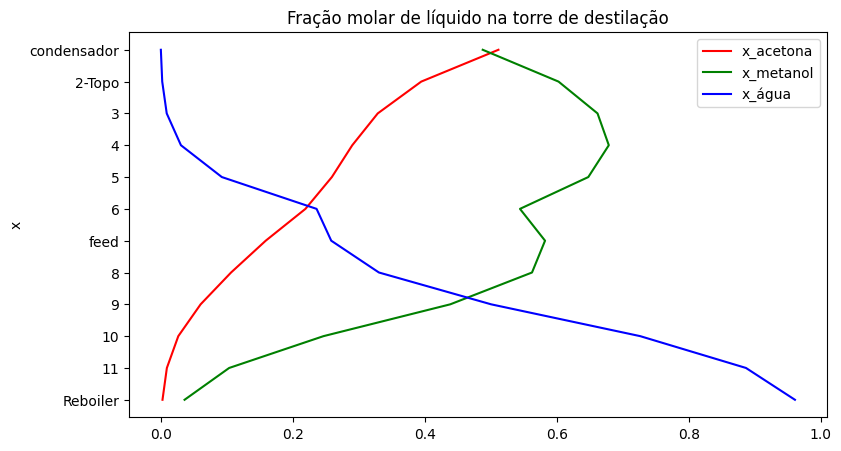

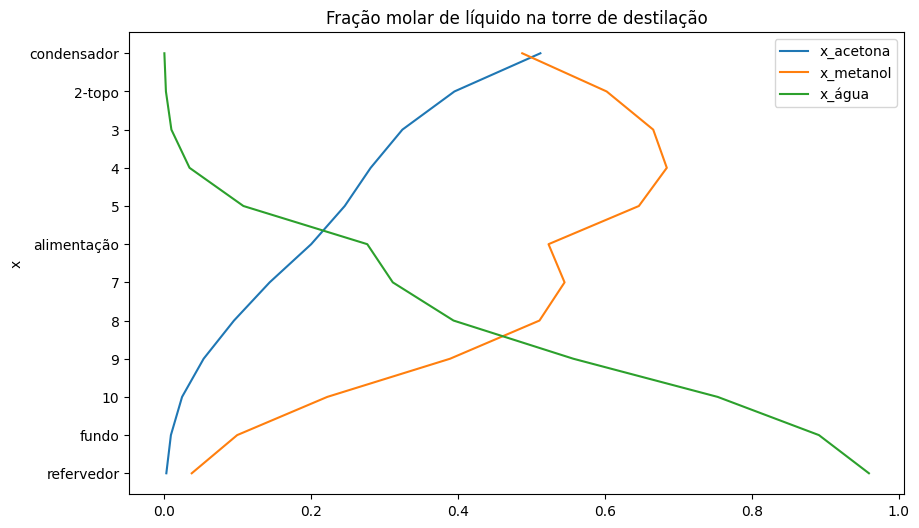

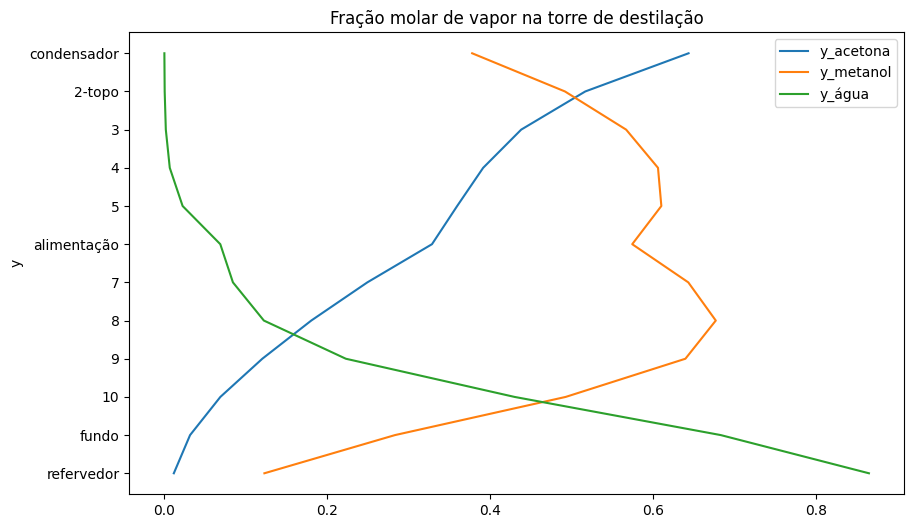

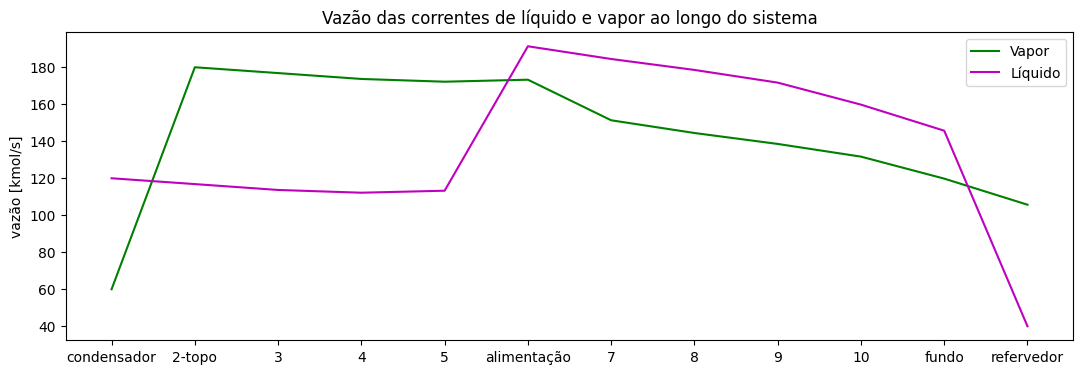

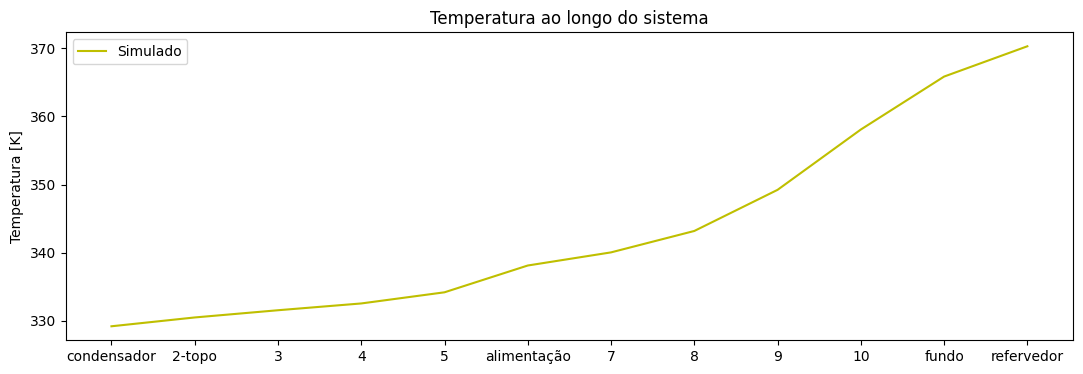

In [ ]:
resultados = f_sim_DestFrac_Thomas_nid(par_coluna, lista_componentes, nome_componente)
resultados

In [ ]:
resultados['Resultado_final']

,condensador,2-topo,3,4,5,alimentação,7,8,9,10,fundo,refervedor
x_acetona,0.512129,0.395149,0.324327,0.281160,0.245875,0.200224,0.143690,0.095183,0.053850,0.024509,0.009319,0.003103
x_metanol,0.487428,0.602306,0.665684,0.684166,0.646138,0.523204,0.545035,0.510892,0.389190,0.222074,0.099517,0.037675
x_água,0.000442,0.002545,0.009989,0.034674,0.107987,0.276572,0.311276,0.393925,0.556960,0.753417,0.891163,0.959223
y_acetona,0.643917,0.517046,0.438321,0.391614,0.359693,0.328775,0.249375,0.180497,0.120378,0.068852,0.031617,0.011672
y_metanol,0.378111,0.492111,0.567274,0.606379,0.610490,0.574724,0.643593,0.677362,0.640056,0.493014,0.283296,0.122921
y_água,0.000073,0.000446,0.001841,0.006692,0.022474,0.068749,0.084264,0.122256,0.222945,0.430173,0.683537,0.865457
V [kg/s],60.000000,180.000000,176.853085,173.679400,172.194215,173.274386,151.341876,144.472188,138.555758,131.697913,119.805919,105.709702
L [kg/s],120.000000,116.853085,113.679400,112.194215,113.274386,191.341876,184.472188,178.555758,171.697913,159.805919,145.709702,40.000000
T [K],329.205162,330.499601,331.558363,332.553649,334.189344,338.120505,340.046457,343.187702,349.221233,358.070818,365.838791,370.283736


In [ ]:
n_alim = 5 # Estágio de alimentação
j = 10 + 2      # número de estágios da coluna + reboiler + condensador
colunas = []

colunas.append('condensador')
colunas.append('2-topo')

rotulo = 3 # o primeiro que será incluído, a menos que ele seja a alimentação

while rotulo < n_alim+1: # pegando cada um dos estágios
  colunas.append(rotulo)
  rotulo += 1

colunas.append('alimentação')
rotulo += 1

while rotulo < j-1: # pegando cada um dos estágios
  colunas.append(rotulo)
  rotulo += 1

colunas.append('fundo')
colunas.append('refervedor')

In [ ]:
colunas

['condensador',
 '2-topo',
 3,
 4,
 5,
 'alimentação',
 7,
 8,
 9,
 10,
 'fundo',
 'refervedor']

In [ ]:
x_eixo = colunas

In [ ]:
x_val_acetona = [0.4999, 0.38369, 0.273101, 0.186398, 0.127232, 0.0857053, 0.0340189, 0.0117743, 0.00320841, 4.6211E-04, 2.5188E-05, 8.8856E-07]
x_val_metanol = [0.493334, 0.600956, 0.694339, 0.747944, 0.743803, 0.663303, 0.689509, 0.658945, 0.538459, 0.277553, 0.0645697, 0.00999911]
x_val_água = [0.00666667, 0.0154158, 0.0325601, 0.0656583, 0.128965, 0.250992, 0.276472, 0.329281, 0.458333, 0.721985, 0.935405, 0.990000]

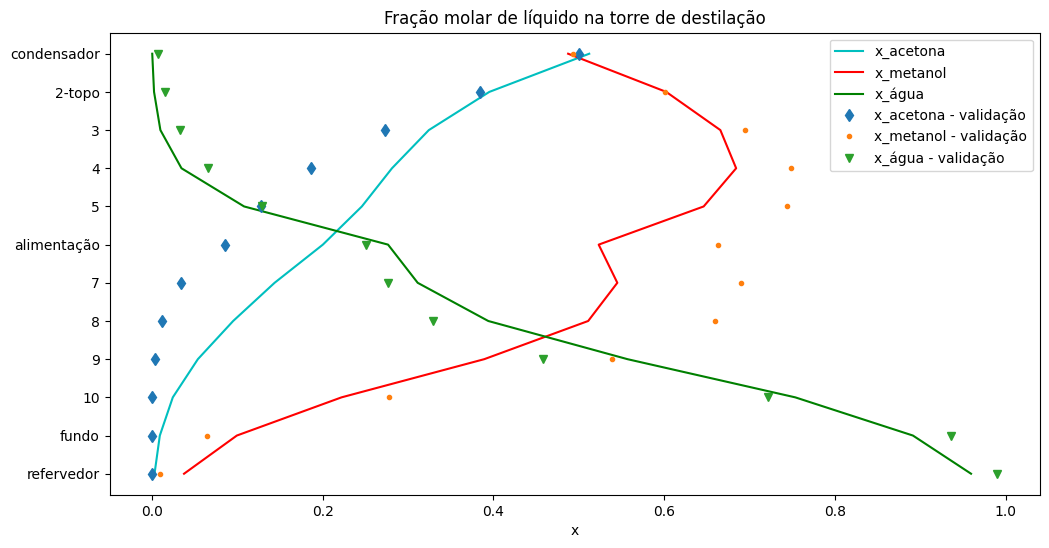

In [ ]:
# Fazendo o gráfico
fig9, ax9 = plt.subplots(figsize =(12,6))
ax9.plot( resultados['x_cada_estagio'][0],x_eixo, 'c', label='x_acetona')
ax9.plot( resultados['x_cada_estagio'][1],x_eixo, 'r', label='x_metanol')
ax9.plot( resultados['x_cada_estagio'][2],x_eixo, 'g', label='x_água')

ax9.plot( x_val_acetona,x_eixo, 'd', label='x_acetona - validação')
ax9.plot( x_val_metanol,x_eixo, '.', label='x_metanol - validação')
ax9.plot( x_val_água,x_eixo, 'v', label='x_água - validação')
# Adicionando texto nos eixos - descrição
ax9.set_xlabel('x')
ax9.invert_yaxis()
# Adicionando título para a figura
ax9.set_title('Fração molar de líquido na torre de destilação')
# Adicionando linha
#ax9.vlines(5,0.0, 1, colors='r', linestyles='dashed')
# Adicionando uma legenda
ax9.legend()

In [ ]:
y_val_acetona = [0.583083, 0.49999, 0.409601, 0.324978, 0.259671, 0.216002, 0.101398, 0.0404311, 0.0140374, 0.00384107, 5.5707E-04, 3.0301E-05]
y_val_metanol = [0.413820, 0.493334, 0.576936, 0.648382, 0.688454, 0.684157, 0.782928, 0.817594, 0.783690, 0.642693, 0.332636, 0.0760534]
y_val_água = [0.00309762, 0.00666667, 0.0134631, 0.0266400, 0.0518748, 0.0998411, 0.115674, 0.141975, 0.202273, 0.353466, 0.666807, 0.923916]

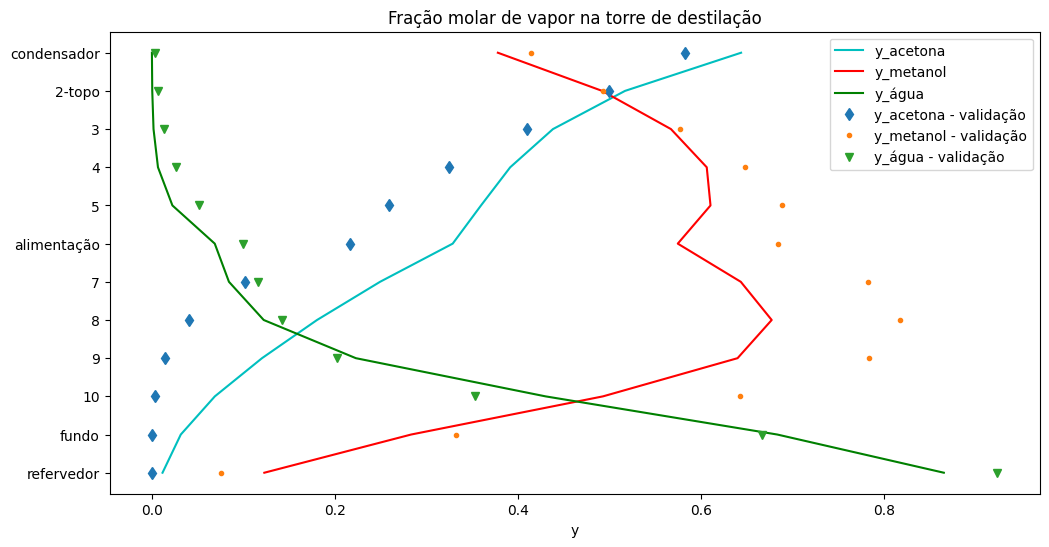

In [ ]:
# Fazendo o gráfico
fig9, ax9 = plt.subplots(figsize =(12,6))
ax9.plot( resultados['y_cada_estagio'][0],x_eixo, 'c', label='y_acetona')
ax9.plot( resultados['y_cada_estagio'][1],x_eixo, 'r', label='y_metanol')
ax9.plot( resultados['y_cada_estagio'][2],x_eixo, 'g', label='y_água')

ax9.plot( y_val_acetona, x_eixo, 'd', label='y_acetona - validação')
ax9.plot( y_val_metanol, x_eixo, '.', label='y_metanol - validação')
ax9.plot( y_val_água, x_eixo, 'v', label='y_água - validação')
# Adicionando texto nos eixos - descrição
ax9.set_xlabel('y')
ax9.invert_yaxis()
# Adicionando título para a figura
ax9.set_title('Fração molar de vapor na torre de destilação')
# Adicionando linha
#ax9.vlines(5,0.0, 1, colors='r', linestyles='dashed')
# Adicionando uma legenda
ax9.legend()

In [ ]:
T_val = [329.600, 330.580, 331.990, 333.670, 335.560, 338.060, 340.350, 342.220, 344.980, 351.480, 363.370, 370.970]
V_val = [60.000, 275.054, 268.832, 262.426, 256.793, 251.955, 218.450, 212.206, 208.087, 202.797, 194.290, 190.080]
L_val = [215.054, 208.832, 202.426, 196.793, 191.995, 258.450, 252.206, 248.087, 242.797, 234.290, 230.080, 40.000]

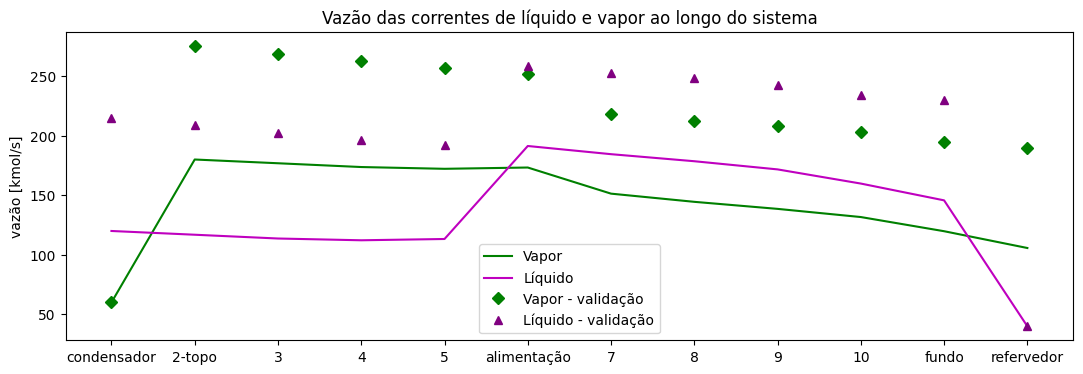

In [ ]:
# Fazendo o gráfico
fig3, ax3 = plt.subplots(figsize =(13,4))
ax3.plot( x_eixo,resultados['V_cada_estagio'], 'g', label='Vapor')
ax3.plot( x_eixo,resultados['L_cada_estagio'], 'm', label='Líquido')

ax3.plot( x_eixo,V_val, marker = 'D', linestyle = 'None', color = 'green', label='Vapor - validação')
ax3.plot( x_eixo,L_val, marker = '^', linestyle = 'None', color = 'purple', label='Líquido - validação')


# Adicionando texto nos eixos - descrição
ax3.set_ylabel('vazão [kmol/s]')
# Adicionando título para a figura
ax3.set_title('Vazão das correntes de líquido e vapor ao longo do sistema')
# Adicionando uma legenda
ax3.legend()

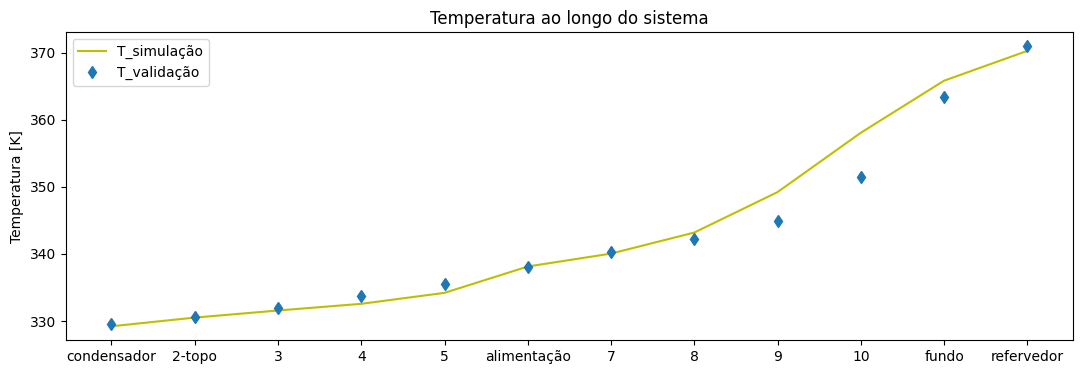

In [ ]:
#Fazendo o gráfico
fig4, ax4 = plt.subplots(figsize =(13,4))
ax4.plot(x_eixo,resultados['Perfil_de_T_final'], 'y',label="T_simulação")
ax4.plot(x_eixo,T_val, 'd',label="T_validação")
# Adicionando texto nos eixos - descrição
ax4.set_ylabel('Temperatura [K]')
# Adicionando título para a figura
ax4.set_title('Temperatura ao longo do sistema')
# Adicionando linha
# Adicionando uma legenda
ax4.legend()

#**Validação usando razão de refluxo = 2 como especificação do topo da coluna**

In [ ]:
x_val_acetona2 = [0.49673, 0.374020, 0.271656, 0.197324, 0.144813, 0.101286, 0.0394881, 0.0131846, 0.00343697, 4.8028E-04, 2.7879E-05, 1.0826E-06]
x_val_metanol2 = [0.490174, 0.595321, 0.667859, 0.692049, 0.660030, 0.559609, 0.594092, 0.572306, 0.466353, 0.239589, 0.0593873, 0.00999892]
x_val_água2 = [0.0130956, 0.0306586, 0.0604856, 0.110627, 0.195157, 0.339105, 0.366420, 0.414509, 0.530210, 0.759931, 0.940585, 0.99000]

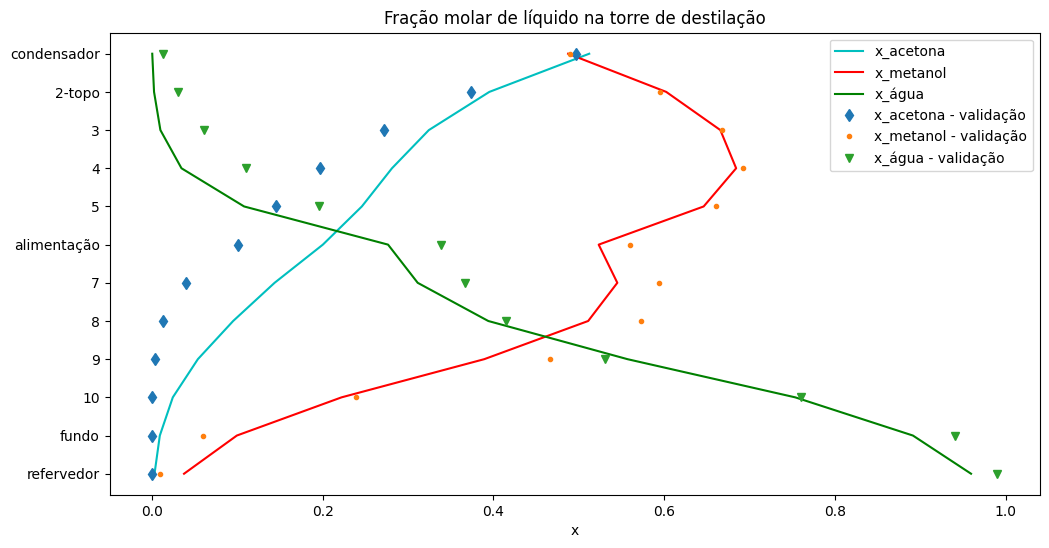

In [ ]:
# Fazendo o gráfico
fig9, ax9 = plt.subplots(figsize =(12,6))
ax9.plot( resultados['x_cada_estagio'][0],x_eixo, 'c', label='x_acetona')
ax9.plot( resultados['x_cada_estagio'][1],x_eixo, 'r', label='x_metanol')
ax9.plot( resultados['x_cada_estagio'][2],x_eixo, 'g', label='x_água')

ax9.plot( x_val_acetona2,x_eixo, 'd', label='x_acetona - validação')
ax9.plot( x_val_metanol2,x_eixo, '.', label='x_metanol - validação')
ax9.plot( x_val_água2,x_eixo, 'v', label='x_água - validação')
# Adicionando texto nos eixos - descrição
ax9.set_xlabel('x')
ax9.invert_yaxis()
# Adicionando título para a figura
ax9.set_title('Fração molar de líquido na torre de destilação')
# Adicionando linha
#ax9.vlines(5,0.0, 1, colors='r', linestyles='dashed')
# Adicionando uma legenda
ax9.legend()

In [ ]:
y_val_acetona2 = [0.58268, 0.496730, 0.415785, 0.349786, 0.303047, 0.271110, 0.130650, 0.0514095, 0.0172632, 0.00452921, 6.3900E-04, 3.6921E-05]
y_val_metanol2 = [0.411272, 0.490174, 0.559534, 0.606079, 0.620765, 0.599072, 0.718950, 0.770434, 0.746268, 0.611426, 0.315632, 0.0760516]
y_val_água2 = [0.00604778, 0.0130956, 0.0246810, 0.0440352, 0.0761880, 0.129818, 0.150400, 0.178156, 0.236468, 0.384045, 0.683729, 0.923912]

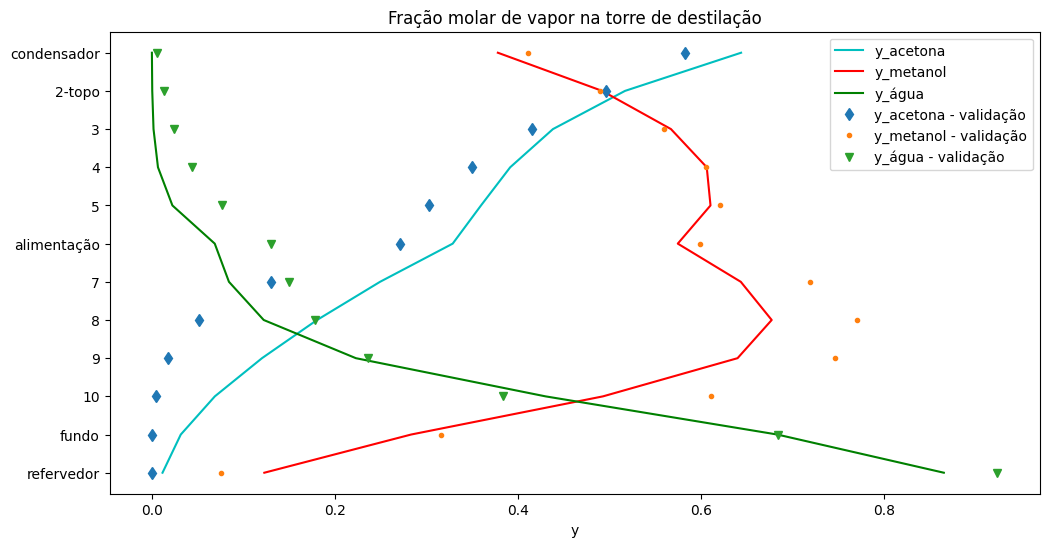

In [ ]:
# Fazendo o gráfico
fig9, ax9 = plt.subplots(figsize =(12,6))
ax9.plot( resultados['y_cada_estagio'][0],x_eixo, 'c', label='y_acetona')
ax9.plot( resultados['y_cada_estagio'][1],x_eixo, 'r', label='y_metanol')
ax9.plot( resultados['y_cada_estagio'][2],x_eixo, 'g', label='y_água')

ax9.plot( y_val_acetona2, x_eixo, 'd', label='y_acetona - validação')
ax9.plot( y_val_metanol2, x_eixo, '.', label='y_metanol - validação')
ax9.plot( y_val_água2, x_eixo, 'v', label='y_água - validação')
# Adicionando texto nos eixos - descrição
ax9.set_xlabel('y')
ax9.invert_yaxis()
# Adicionando título para a figura
ax9.set_title('Fração molar de vapor na torre de destilação')
# Adicionando linha
#ax9.vlines(5,0.0, 1, colors='r', linestyles='dashed')
# Adicionando uma legenda
ax9.legend()

In [ ]:
T_val2 = [329.680, 330.820, 332.260, 333.900, 335.810, 338.500, 341.340, 343.530, 346.370, 352.760, 363.920, 370.970]
L_val2 = [120.790, 117.054, 113.589, 110.643, 107.891, 176.214, 170.788, 167.623, 164.191, 159.181, 156.984, 39.6051]
V_val2 = [60.3949, 181.185, 177.449, 173.984, 171.038, 168.286, 136.609, 131.183, 128.018, 124.586, 119.576, 117.379]

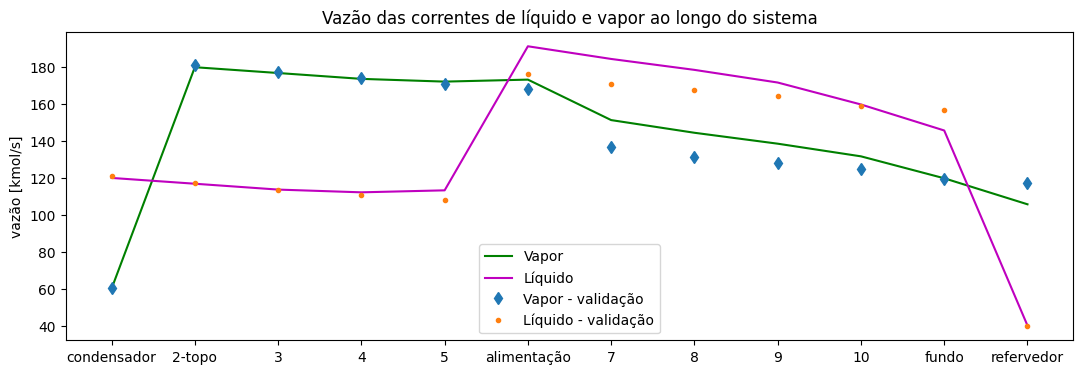

In [ ]:
# Fazendo o gráfico
fig3, ax3 = plt.subplots(figsize =(13,4))
ax3.plot( x_eixo,resultados['V_cada_estagio'], 'g', label='Vapor')
ax3.plot( x_eixo,resultados['L_cada_estagio'], 'm', label='Líquido')

ax3.plot( x_eixo,V_val2, 'd', label='Vapor - validação')
ax3.plot( x_eixo,L_val2, '.', label='Líquido - validação')


# Adicionando texto nos eixos - descrição
ax3.set_ylabel('vazão [kmol/s]')
# Adicionando título para a figura
ax3.set_title('Vazão das correntes de líquido e vapor ao longo do sistema')
# Adicionando uma legenda
ax3.legend()

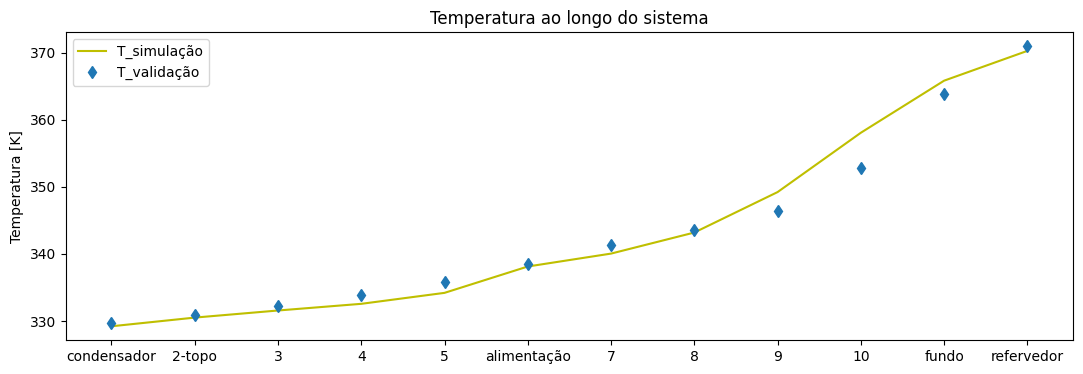

In [ ]:
#Fazendo o gráfico
fig4, ax4 = plt.subplots(figsize =(13,4))
ax4.plot(x_eixo,resultados['Perfil_de_T_final'], 'y',label="T_simulação")
ax4.plot(x_eixo,T_val2, 'd',label="T_validação")
# Adicionando texto nos eixos - descrição
ax4.set_ylabel('Temperatura [K]')
# Adicionando título para a figura
ax4.set_title('Temperatura ao longo do sistema')
# Adicionando linha
# Adicionando uma legenda
ax4.legend()

#**Cálculo dos erros entre as medidas**

In [ ]:
R = resultados['Resultado_final'].transpose()
#R

In [ ]:
#Dados da simulação no simulador não ideal
data = {
    'x_Acetona': [0.515509, 0.448646, 0.404525, 0.371965, 0.335776, 0.276547, 0.240406, 0.201920, 0.154820, 0.097289, 0.047146, 0.018437],
    'x_metanol': [0.484119, 0.549266, 0.587210, 0.598482, 0.568064, 0.464579, 0.488496, 0.492376, 0.442798, 0.309266, 0.154913, 0.059449],
    'x_água': [0.000372, 0.002087, 0.008265, 0.029553, 0.096160, 0.258874, 0.271098, 0.305704, 0.402382, 0.593444, 0.797941, 0.922114],
    'y_Acetona': [0.569801, 0.506402, 0.464801, 0.436488, 0.411386, 0.379868, 0.338322, 0.296136, 0.249572, 0.192070, 0.121211, 0.057248],
    'y_metanol': [0.408113, 0.475573, 0.520095, 0.544513, 0.546067, 0.516797, 0.560487, 0.595550, 0.604438, 0.547404, 0.385073, 0.188511],
    'y_água': [0.000063, 0.000366, 0.001488, 0.005492, 0.019070, 0.061019, 0.066285, 0.079564, 0.120852, 0.242525, 0.488232, 0.754291],
    'V [kg/s]': [60.000000, 180.000000, 175.633716, 172.597418, 171.225766, 172.147059, 151.794399, 146.571942, 141.665498, 136.848750, 128.955414, 113.671171],
    'L [kg/s]': [120.000000, 115.633716, 112.597418, 111.225766, 112.147059, 191.794399, 186.571942, 181.665498, 176.848750, 168.955414, 153.671171, 40.000000],
    'T [K]': [329.821458, 330.491903, 331.063831, 331.743918, 333.146973, 336.940383, 337.757986, 339.162679, 342.435761, 349.732060, 359.865809, 367.595162]
}

df = pd.DataFrame(data, index=['condensador', '2', '3', '4', '5', 'alimentação', '7', '8', '9', '10', 'fundo', 'refervedor'])

#Dados de validação com vazão de destilado especificada no topo

x_val_acetona = [0.4999, 0.38369, 0.273101, 0.186398, 0.127232, 0.0857053, 0.0340189, 0.0117743, 0.00320841, 4.6211E-04, 2.5188E-05, 8.8856E-07]
x_val_metanol = [0.493334, 0.600956, 0.694339, 0.747944, 0.743803, 0.663303, 0.689509, 0.658945, 0.538459, 0.277553, 0.0645697, 0.00999911]
x_val_água = [0.00666667, 0.0154158, 0.0325601, 0.0656583, 0.128965, 0.250992, 0.276472, 0.329281, 0.458333, 0.721985, 0.935405, 0.990000]
y_val_acetona = [0.583083, 0.49999, 0.409601, 0.324978, 0.259671, 0.216002, 0.101398, 0.0404311, 0.0140374, 0.00384107, 5.5707E-04, 3.0301E-05]
y_val_metanol = [0.413820, 0.493334, 0.576936, 0.648382, 0.688454, 0.684157, 0.782928, 0.817594, 0.783690, 0.642693, 0.332636, 0.0760534]
y_val_água = [0.00309762, 0.00666667, 0.0134631, 0.0266400, 0.0518748, 0.0998411, 0.115674, 0.141975, 0.202273, 0.353466, 0.666807, 0.923916]
T_val = [329.600, 330.580, 331.990, 333.670, 335.560, 338.060, 340.350, 342.220, 344.980, 351.480, 363.370, 370.970]
V_val = [60.000, 275.054, 268.832, 262.426, 256.793, 251.955, 218.450, 212.206, 208.087, 202.797, 194.290, 190.080]
L_val = [215.054, 208.832, 202.426, 196.793, 191.995, 258.450, 252.206, 248.087, 242.797, 234.290, 230.080, 40.000]

# Inicializando listas para armazenar os erros individuais
erros_x_acetona = []
erros_x_metanol = []
erros_x_água = []
erros_y_acetona = []
erros_y_metanol = []
erros_y_água = []
erros_V = []
erros_L = []
erros_T = []

# Calculando os erros para cada estágio
for i in range(len(df.index)):
    erros_x_acetona.append(np.abs(df['x_Acetona'][i] - x_val_acetona[i]))
    erros_x_metanol.append(np.abs(df['x_metanol'][i] - x_val_metanol[i]))
    erros_x_água.append(np.abs(df['x_água'][i] - x_val_água[i]))
    erros_y_acetona.append(np.abs(df['y_Acetona'][i] - y_val_acetona[i]))
    erros_y_metanol.append(np.abs(df['y_metanol'][i] - y_val_metanol[i]))
    erros_y_água.append(np.abs(df['y_água'][i] - y_val_água[i]))
    erros_V.append(np.abs(df['V [kg/s]'][i] - V_val[i]))
    erros_L.append(np.abs(df['L [kg/s]'][i] - L_val[i]))
    erros_T.append(np.abs(df['T [K]'][i] - T_val[i]))

# Criando o DataFrame de erros
erros_data = {
    'erro_x_Acetona': erros_x_acetona,
    'erro_x_metanol': erros_x_metanol,
    'erro_x_água': erros_x_água,
    'erro_y_Acetona': erros_y_acetona,
    'erro_y_metanol': erros_y_metanol,
    'erro_y_água': erros_y_água,
    'erro_V': erros_V,
    'erro_L': erros_L,
    'erro_T': erros_T
}

df_erros = pd.DataFrame(erros_data, index=df.index)

# Adicionando a linha de somatório dos erros
df_erros.loc['Somatório dos Erros'] = df_erros.sum()


# Exibindo o DataFrame de erros
df_erros

,erro_x_Acetona,erro_x_metanol,erro_x_água,erro_y_Acetona,erro_y_metanol,erro_y_água,erro_V,erro_L,erro_T
condensador,0.015609,0.009215,0.006295,0.013282,0.005707,0.003035,0.000000,95.054000,0.221458
2,0.064956,0.051690,0.013329,0.006412,0.017761,0.006301,95.054000,93.198284,0.088097
3,0.131424,0.107129,0.024295,0.055200,0.056841,0.011975,93.198284,89.828582,0.926169
4,0.185567,0.149462,0.036105,0.111510,0.103869,0.021148,89.828582,85.567234,1.926082
5,0.208544,0.175739,0.032805,0.151715,0.142387,0.032805,85.567234,79.847941,2.413027
alimentação,0.190842,0.198724,0.007882,0.163866,0.167360,0.038822,79.807941,66.655601,1.119617
7,0.206387,0.201013,0.005374,0.236924,0.222441,0.049389,66.655601,65.634058,2.592014
8,0.190146,0.166569,0.023577,0.255705,0.222044,0.062411,65.634058,66.421502,3.057321
9,0.151612,0.095661,0.055951,0.235535,0.179252,0.081421,66.421502,65.948250,2.544239
10,0.096827,0.031713,0.128541,0.188229,0.095289,0.110941,65.948250,65.334586,1.747940


In [ ]:
#Dados da simulação no simulador não ideal
data = {
    'x_Acetona': [0.515509, 0.448646, 0.404525, 0.371965, 0.335776, 0.276547, 0.240406, 0.201920, 0.154820, 0.097289, 0.047146, 0.018437],
    'x_metanol': [0.484119, 0.549266, 0.587210, 0.598482, 0.568064, 0.464579, 0.488496, 0.492376, 0.442798, 0.309266, 0.154913, 0.059449],
    'x_água': [0.000372, 0.002087, 0.008265, 0.029553, 0.096160, 0.258874, 0.271098, 0.305704, 0.402382, 0.593444, 0.797941, 0.922114],
    'y_Acetona': [0.569801, 0.506402, 0.464801, 0.436488, 0.411386, 0.379868, 0.338322, 0.296136, 0.249572, 0.192070, 0.121211, 0.057248],
    'y_metanol': [0.408113, 0.475573, 0.520095, 0.544513, 0.546067, 0.516797, 0.560487, 0.595550, 0.604438, 0.547404, 0.385073, 0.188511],
    'y_água': [0.000063, 0.000366, 0.001488, 0.005492, 0.019070, 0.061019, 0.066285, 0.079564, 0.120852, 0.242525, 0.488232, 0.754291],
    'V [kg/s]': [60.000000, 180.000000, 175.633716, 172.597418, 171.225766, 172.147059, 151.794399, 146.571942, 141.665498, 136.848750, 128.955414, 113.671171],
    'L [kg/s]': [120.000000, 115.633716, 112.597418, 111.225766, 112.147059, 191.794399, 186.571942, 181.665498, 176.848750, 168.955414, 153.671171, 40.000000],
    'T [K]': [329.821458, 330.491903, 331.063831, 331.743918, 333.146973, 336.940383, 337.757986, 339.162679, 342.435761, 349.732060, 359.865809, 367.595162]
}

df = pd.DataFrame(data, index=['condensador', '2', '3', '4', '5', 'alimentação', '7', '8', '9', '10', 'fundo', 'refervedor'])

#Dados de validação com razão de refluxo especificada no topo

x_val_acetona2 = [0.49673, 0.374020, 0.271656, 0.197324, 0.144813, 0.101286, 0.0394881, 0.0131846, 0.00343697, 4.8028E-04, 2.7879E-05, 1.0826E-06]
x_val_metanol2 = [0.490174, 0.595321, 0.667859, 0.692049, 0.660030, 0.559609, 0.594092, 0.572306, 0.466353, 0.239589, 0.0593873, 0.00999892]
x_val_água2 = [0.0130956, 0.0306586, 0.0604856, 0.110627, 0.195157, 0.339105, 0.366420, 0.414509, 0.530210, 0.759931, 0.940585, 0.99000]
y_val_acetona2 = [0.58268, 0.496730, 0.415785, 0.349786, 0.303047, 0.271110, 0.130650, 0.0514095, 0.0172632, 0.00452921, 6.3900E-04, 3.6921E-05]
y_val_metanol2 = [0.411272, 0.490174, 0.559534, 0.606079, 0.620765, 0.599072, 0.718950, 0.770434, 0.746268, 0.611426, 0.315632, 0.0760516]
y_val_água2 = [0.00604778, 0.0130956, 0.0246810, 0.0440352, 0.0761880, 0.129818, 0.150400, 0.178156, 0.236468, 0.384045, 0.683729, 0.923912]
T_val2 = [329.680, 330.820, 332.260, 333.900, 335.810, 338.500, 341.340, 343.530, 346.370, 352.760, 363.920, 370.970]
L_val2 = [120.790, 117.054, 113.589, 110.643, 107.891, 176.214, 170.788, 167.623, 164.191, 159.181, 156.984, 39.6051]
V_val2 = [60.3949, 181.185, 177.449, 173.984, 171.038, 168.286, 136.609, 131.183, 128.018, 124.586, 119.576, 117.379]


# Inicializando listas para armazenar os erros individuais
erros_x_acetona2 = []
erros_x_metanol2 = []
erros_x_água2 = []
erros_y_acetona2 = []
erros_y_metanol2 = []
erros_y_água2 = []
erros_V2 = []
erros_L2 = []
erros_T2 = []

# Calculando os erros para cada estágio
for i in range(len(df.index)):
    erros_x_acetona2.append(np.abs(df['x_Acetona'][i] - x_val_acetona2[i]))
    erros_x_metanol2.append(np.abs(df['x_metanol'][i] - x_val_metanol2[i]))
    erros_x_água2.append(np.abs(df['x_água'][i] - x_val_água2[i]))
    erros_y_acetona2.append(np.abs(df['y_Acetona'][i] - y_val_acetona2[i]))
    erros_y_metanol2.append(np.abs(df['y_metanol'][i] - y_val_metanol2[i]))
    erros_y_água2.append(np.abs(df['y_água'][i] - y_val_água2[i]))
    erros_V2.append(np.abs(df['V [kg/s]'][i] - V_val2[i]))
    erros_L2.append(np.abs(df['L [kg/s]'][i] - L_val2[i]))
    erros_T2.append(np.abs(df['T [K]'][i] - T_val2[i]))

# Criando o DataFrame de erros
erros_data_2 = {
    'erro_x_Acetona': erros_x_acetona2,
    'erro_x_metanol': erros_x_metanol2,
    'erro_x_água': erros_x_água2,
    'erro_y_Acetona': erros_y_acetona2,
    'erro_y_metanol': erros_y_metanol2,
    'erro_y_água': erros_y_água2,
    'erro_V': erros_V2,
    'erro_L': erros_L2,
    'erro_T': erros_T2
}

df_erros_2 = pd.DataFrame(erros_data_2, index=df.index)

# Adicionando a linha de somatório dos erros
df_erros_2.loc['Somatório dos Erros'] = df_erros_2.sum()

# Exibindo o DataFrame de erros
df_erros_2

,erro_x_Acetona,erro_x_metanol,erro_x_água,erro_y_Acetona,erro_y_metanol,erro_y_água,erro_V,erro_L,erro_T
condensador,0.018779,0.006055,0.012724,0.012879,0.003159,0.005985,0.394900,0.790000,0.141458
2,0.074626,0.046055,0.028572,0.009672,0.014601,0.012730,1.185000,1.420284,0.328097
3,0.132869,0.080649,0.052221,0.049016,0.039439,0.023193,1.815284,0.991582,1.196169
4,0.174641,0.093567,0.081074,0.086702,0.061566,0.038543,1.386582,0.582766,2.156082
5,0.190963,0.091966,0.098997,0.108339,0.074698,0.057118,0.187766,4.256059,2.663027
alimentação,0.175261,0.095030,0.080231,0.108758,0.082275,0.068799,3.861059,15.580399,1.559617
7,0.200918,0.105596,0.095322,0.207672,0.158463,0.084115,15.185399,15.783942,3.582014
8,0.188735,0.079930,0.108805,0.244727,0.174884,0.098592,15.388942,14.042498,4.367321
9,0.151383,0.023555,0.127828,0.232309,0.141830,0.115616,13.647498,12.657750,3.934239
10,0.096809,0.069677,0.166487,0.187541,0.064022,0.141520,12.262750,9.774414,3.027940
